# Taxi demand prediction in New York City


<img src='new_york.gif'>

In [1]:
import matplotlib
import time 
import dask.dataframe as dd
import matplotlib.pylab as plt
matplotlib.use('nbagg')
import pandas as pd
import seaborn as sns
from matplotlib import rcParams 
import folium 
import datetime 
import numpy as np
import pickle
import os
import gpxpy.geo 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Data Information

<p>
We downloaded this data from : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page (2022 & 2023 data) and kaggle
</p>

## Taxi information:

<h5>Yellow color Taxi:  </h5>
<p> These are the well known taxis in New York City. They provide logistics exclusively via street-hails. The quantity of taxicabs is regulated by the licensing authority commission which is in turn itself limited to a finite number of medallions. To utilize this kind of car service, you have to wave at the driver with your hand by standing at the roadside and if the taxi in the street is vacant. The pick-ups are not fixed where you don't have to schedule to car.</p>

<p> Credits: Quora</p>

<h5>Footnote:</h5>
In this jupyter notebook our team is considering only the yellow taxis for the time period between Jan - Mar 2022 & Jan - Mar 2023

In [2]:
def print_column_names(dataframe):
    """
    Print the column names of the given DataFrame.
    
    Parameters:
    dataframe (dask.dataframe.DataFrame): The DataFrame whose column names need to be printed.
    """
    print(dataframe.columns)

# If the dataset is too large to fit into memory, consider using Dask DataFrame
# Dask DataFrame documentation: https://docs.dask.org/en/latest/dataframe.html

# Reading data for January 2022
month = dd.read_csv('data/yellow_tripdata_2022-01.csv')

# Reading data for January 2023
month_jan_2023 = dd.read_csv('data/yellow_tripdata_2023-01.csv')

# Reading data for February 2023
month_feb_2023 = dd.read_csv('data/yellow_tripdata_2023-02.csv')

# Reading data for March 2023
month_mar_2023 = dd.read_csv('data/yellow_tripdata_2023-03.csv')

# Using the print_column_names method to print column names
print_column_names(month)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when ride was started</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the ride was ended</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>It represents no.of passengers in cab. this was entered directly by driver</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The traveeled trip distance in miles shown in the meter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>longitude coordinates of pickup spot</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude coordinated of pickup spot</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li>  JFK  </li>
			<li> Standard rate</li>
			<li> Negotiated fare</li>
			<li>Group ride </li>
			<li> Newark  </li>
			<li>  Nassau or Westchester</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store            and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>
	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude Coordinated of drop off point</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude coordinated of dropoff point.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numericcal value representing how the passenger paid for the ride.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2022.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

# Performance metrics(we are considering these 2 metrics for this use case)
1. Mean Squared error.
2. Mean Absolute percentage error.

## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [8]:
def visualize_dataframe_head(dataframe, n=5):
    """
    Visualize the first few rows of the given DataFrame using pandas.
    """
    print(dataframe.head(n))
    
visualize_dataframe_head(month, 5)

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1

### 1. Pickup Latitude and Pickup Longitude

It's understood from the source at https://www.flickr.com/places/info/2459115 that New York is defined by the geographical coordinates (latitude, longitude) of (40.5774, -74.15) & (40.9176,-73.7004). Therefore, we only consider pickups originating within these coordinates, as our focus is exclusively on pickups within New York City.

In [11]:
# We aim to identify points falling outside the geographic boundaries of New York City and store them in 'outlier_locations'
ny_boundary_outliers = month[
    ((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774) |
     (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))
]


# For further details on Folium, refer to its documentation: http://folium.readthedocs.io/en/latest/quickstart.html

# Initializing a Folium map centered around a specific location in New York City
nyc_map = folium.Map(location=[40.734695, -73.990372])

# Extract a sample subset of outlier locations for visualization
temp_outliers = ny_boundary_outliers.head(10000)

# Plot markers for each outlier location on the Folium map
for idx, outlier in temp_outliers.iterrows():
    if int(outlier['pickup_latitude']) != 0:
        folium.Marker([outlier['pickup_latitude'], outlier['pickup_longitude']]).add_to(nyc_map)

# Display the Folium map with outlier locations
nyc_map


### 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [12]:
# Filter dropoff locations outside the defined boundaries of New York City
ny_dropoff_outliers = month[
    ((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774) |
     (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))
]

# Initialize a Folium map centered around a base location
# For more information on Folium, see: http://folium.readthedocs.io/en/latest/quickstart.html
nyc_map = folium.Map(location=[40.734695, -73.990372])

# Extract a sample subset of outlier dropoff locations for visualization
sample_dropoff_outliers = ny_dropoff_outliers.head(10000)

# Plot markers for each outlier dropoff location on the Folium map
for idx, dropoff in sample_dropoff_outliers.iterrows():
    if int(dropoff['pickup_latitude']) != 0:
        folium.Marker([dropoff['dropoff_latitude'], dropoff['dropoff_longitude']]).add_to(nyc_map)

# Display the Folium map with outlier dropoff locations
nyc_map


### 3. Duration of trips:

<p style="font-size:18px">According to New York City's Taxi Commission's rules<b style= "color:blue">the maximum trip duration in a 24 hour interval can be around 12 hours.</b> </p>

In [13]:
# The timestamps are converted to Unix time for trip-time and speed calculation, as well as pickup-times in Unix. 
# These values will be used for binning



def calculate_tripTimes(month):
    # Extracting pickup and dropoff datetime and converting them to Unix time
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #dropoffs & pickups to unix time
    duration_pickup = [unixConversion(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [unixConversion(x) for x in duration['tpep_dropoff_datetime'].values]
    #we are calculating trip duration calculation
    # Calculating trip duration in minutes
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    # Creating a new DataFrame with relevant columns and calculated trip times and speed
    newDataFrame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    newDataFrame['trip_times'] = durations
    newDataFrame['pickup_times'] = duration_pickup
    newDataFrame['Speed'] = 60*(newDataFrame['trip_distance']/newDataFrame['trip_times'])
    
    return newDataFrame
# For information on Unix time conversion, see: https://stackoverflow.com/a/27914405
def unixConversion(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
frameWithDurations = calculate_tripTimes(month)

In [14]:
print(frameWithDurations.head())

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421367e+09   5.285319  
1  1.420940e+09   9.983193  
2  1.420940e+09  10.746269  
3  1.420940e+09  16.071429  
4  1.420940e+

In [15]:
%matplotlib inline


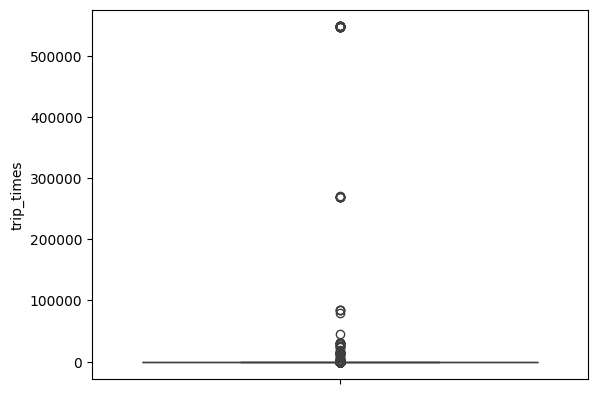

In [16]:
# Visualizing trip duration distribution using a box plot to identify potential outliers
sns.boxplot(y="trip_times", data =frameWithDurations)
plt.show()

In [18]:
# Calculating percentiles from 0 to 100 to determine the optimal percentile for outlier removal
for i in range(0, 100, 10):
    trip_times_sorted = np.sort(frameWithDurations["trip_times"].values)
    percentile_value = trip_times_sorted[int(len(trip_times_sorted) * (float(i) / 100))]
    print("{}th percentile value is {}".format(i, percentile_value))

# Calculating the 100th percentile value
print("100th percentile value is", trip_times_sorted[-1])


0th percentile value is -1211.0166666666667
10th percentile value is 3.8333333333333335
20th percentile value is 5.383333333333334
30th percentile value is 6.816666666666666
40th percentile value is 8.3
50th percentile value is 9.95
60th percentile value is 11.866666666666667
70th percentile value is 14.283333333333333
80th percentile value is 17.633333333333333
90th percentile value is 23.45
100th percentile value is 548555.6333333333


In [19]:
# Examining percentiles beyond the 99th percentile
for i in range(90, 100):
    trip_times_sorted = np.sort(frameWithDurations["trip_times"].values)
    percentile_value = trip_times_sorted[int(len(trip_times_sorted) * (float(i) / 100))]
    print("{}th percentile value is {}".format(i, percentile_value))

# Calculating the 100th percentile value
print("100th percentile value is", trip_times_sorted[-1])

90th percentile value is 23.45
91th percentile value is 24.35
92th percentile value is 25.383333333333333
93th percentile value is 26.55
94th percentile value is 27.933333333333334
95th percentile value is 29.583333333333332
96th percentile value is 31.683333333333334
97th percentile value is 34.46666666666667
98th percentile value is 38.71666666666667
99th percentile value is 46.75
100th percentile value is 548555.6333333333


In [20]:
#removing data points depending upon ouur analysis and TLC regulations
frameWithDurations_modified=frameWithDurations[(frameWithDurations.trip_times>1) & (frameWithDurations.trip_times<720)]

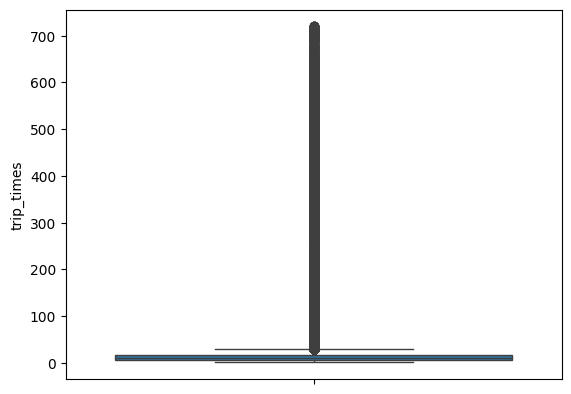

In [21]:
# Box plot after removal of outliers
sns.boxplot(y="trip_times", data =frameWithDurations_modified)
plt.show()

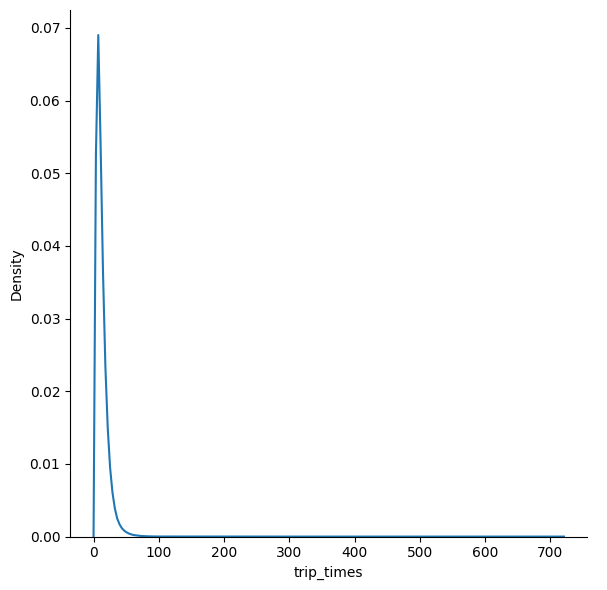

In [22]:
# Probability Density Function (PDF) of trip times after removing outliers
sns.FacetGrid(frameWithDurations_modified,height=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [23]:
import math
#we are trying to convert the values to log-values to chec for log-normal


frameWithDurations_modified['log_times']=[math.log(i) for i in frameWithDurations_modified['trip_times'].values]

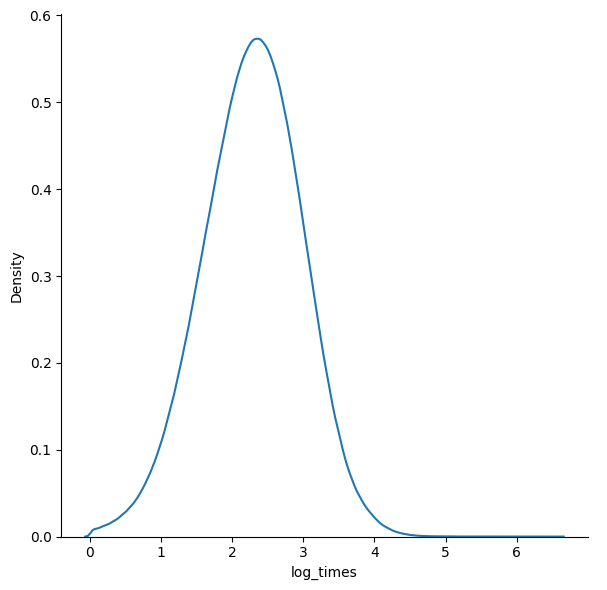

In [25]:
# Probability Density Function (PDF) of log-values
sns.FacetGrid(frameWithDurations_modified,height=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

In [26]:
import scipy.stats as stats

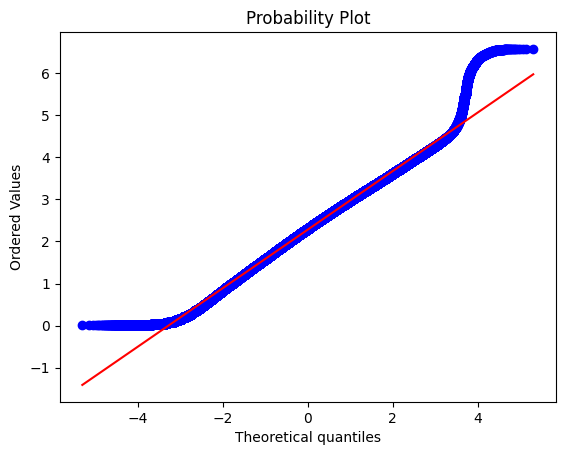

In [27]:
#pltting the Q-Q plot fto check whether trip-times is log-normal
stats.probplot(frameWithDurations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed

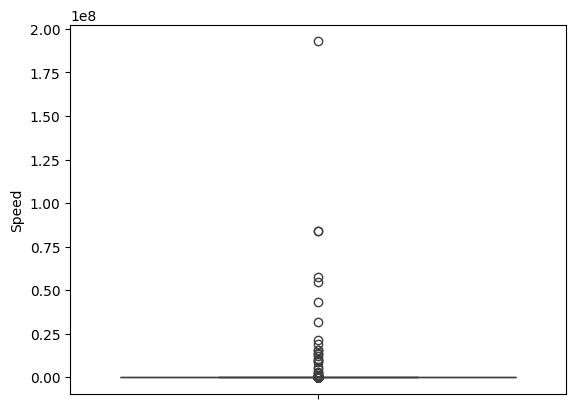

In [28]:
# Checking for outliers in the data after removing trip duration outliers
# Box plot for speeds without outliers
frameWithDurations_modified['Speed'] = 60*(frameWithDurations_modified['trip_distance']/frameWithDurations_modified['trip_times'])
sns.boxplot(y="Speed", data =frameWithDurations_modified)
plt.show()

In [31]:
# Computing percentiles for speed values
for i in range(0, 100, 10):
    speed_values_sorted = np.sort(frameWithDurations_modified["Speed"].values)
    percentile_value = speed_values_sorted[int(len(speed_values_sorted) * (float(i) / 100))]
    print("{}th percentile value is {}".format(i, percentile_value))

# Computing the 100th percentile value
print("100th percentile value is", speed_values_sorted[-1])

0th percentile value is 0.0
10th percentile value is 6.409495548961425
20th percentile value is 7.80952380952381
30th percentile value is 8.929133858267717
40th percentile value is 9.98019801980198
50th percentile value is 11.06865671641791
60th percentile value is 12.286689419795222
70th percentile value is 13.796407185628745
80th percentile value is 15.963224893917962
90th percentile value is 20.186915887850468
100th percentile value is 192857142.85714284


In [32]:
# Calculating speed values at percentiles 90 to 100
for i in range(90, 100):
    speed_values_sorted = np.sort(frameWithDurations_modified["Speed"].values)
    percentile_value = speed_values_sorted[int(len(speed_values_sorted) * (float(i) / 100))]
    print("{} percentile value is {}".format(i, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is", speed_values_sorted[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is 192857142.85714284


In [33]:
# Finding speed values at percentiles 99 to 100
for i in np.arange(0.0, 1.0, 0.1):
    speed_values_sorted = np.sort(frameWithDurations_modified["Speed"].values)
    percentile_value = speed_values_sorted[int(len(speed_values_sorted) * (99.0 + i) / 100)]
    print("{:.1f} percentile value is {:.2f}".format(99.0 + i, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is {:.2f}".format(speed_values_sorted[-1]))

99.0 percentile value is 35.75
99.1 percentile value is 36.31
99.2 percentile value is 36.91
99.3 percentile value is 37.59
99.4 percentile value is 38.33
99.5 percentile value is 39.18
99.6 percentile value is 40.15
99.7 percentile value is 41.34
99.8 percentile value is 42.87
99.9 percentile value is 45.31
100 percentile value is 192857142.86


In [34]:
# Removing additional outliers based on the 99.9th percentile value
frameWithDurations_modified=frameWithDurations[(frameWithDurations.Speed>0) & (frameWithDurations.Speed<45.31)]

In [35]:
# mean of speed of taxisss in New-York City
sum(frameWithDurations_modified["Speed"]) / float(len(frameWithDurations_modified["Speed"]))

12.450173996028015

<b style='font-size:16px'>The average velocity in Newyork city is 12.45 M/hr, so a taxi driver could travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

### 5. Distance of the trip

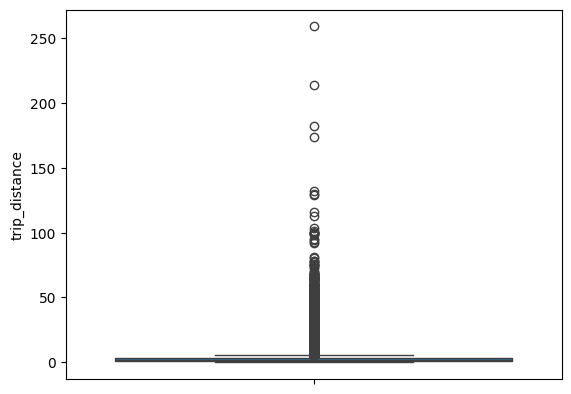

In [36]:
# we decided to try if there are any outliers in trip distance
# box-plot showing outliers in distance values of the trop
sns.boxplot(y="trip_distance", data =frameWithDurations_modified)
plt.show()

In [37]:
# Finding trip distance values at percentiles 0 to 100
for i in range(0, 100, 10):
    trip_distance_sorted = np.sort(frameWithDurations_modified["trip_distance"].values)
    percentile_value = trip_distance_sorted[int(len(trip_distance_sorted) * (float(i) / 100))]
    print("{} percentile value is {}".format(i, percentile_value))

# Finding the 100th percentile value
print("100 percentile value is", trip_distance_sorted[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is 258.9


In [39]:
# Finding trip distance values at percentiles 90 to 100
for i in range(90, 100):
    trip_distance_sorted = np.sort(frameWithDurations_modified["trip_distance"].values)
    percentile_value = trip_distance_sorted[int(len(trip_distance_sorted) * (float(i) / 100))]
    print("{} percentile value is {}".format(i, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is", trip_distance_sorted[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is 258.9


In [40]:
# Finding trip distance values at percentiles 99 to 100
for i in np.arange(0.0, 1.0, 0.1):
    trip_distance_sorted = np.sort(frameWithDurations_modified["trip_distance"].values)
    percentile_value = trip_distance_sorted[int(len(trip_distance_sorted) * (99.0 + i) / 100)]
    print("{:.1f} percentile value is {:.2f}".format(99.0 + i, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is {:.2f}".format(trip_distance_sorted[-1]))

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.60
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.50
99.6 percentile value is 19.96
99.7 percentile value is 20.50
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is 258.90


In [41]:
#we wanty to remove additional outliers based on the 99.9th percentile value
frameWithDurations_modified=frameWithDurations[(frameWithDurations.trip_distance>0) & (frameWithDurations.trip_distance<23)]

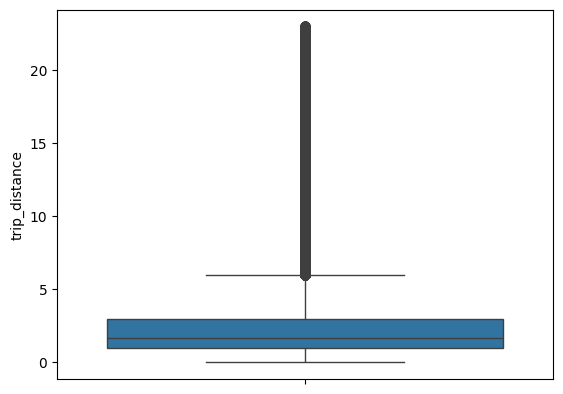

In [42]:
# Box plot after removal of outliers for trip distance
sns.boxplot(y="trip_distance", data=frameWithDurations_modified)
plt.show()

### 6. Fare of the trip

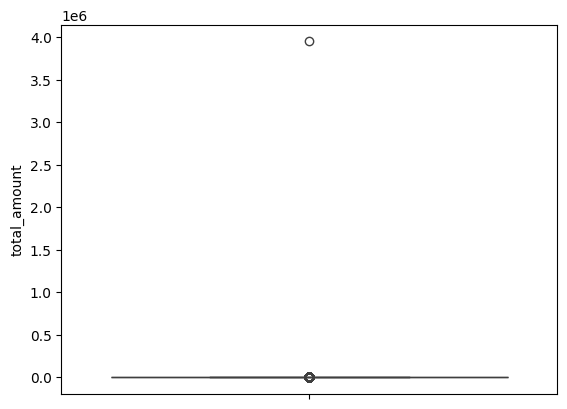

In [43]:
# Checking for outliers in total fare based on the cleaned dataset
sns.boxplot(y="total_amount", data=frameWithDurations_modified)
plt.show()

In [48]:
# Calculating total fare amount values at percentiles 0 to 100
for id in range(0, 100, 10):
    total_amount_sorted = np.sort(frameWithDurations_modified["total_amount"].values)
    percentile_value = total_amount_sorted[int(len(total_amount_sorted) * (float(id) / 100))]
    print("{} percentile value is {}".format(id, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is", total_amount_sorted[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is 3950611.6


In [47]:
# apparently we need to again find the total fare amount values at percentiles 90 to 100
for id in range(90, 100):
    total_amount_sorted = np.sort(frameWithDurations_modified["total_amount"].values)
    percentile_value = total_amount_sorted[int(len(total_amount_sorted) * (float(id) / 100))]
    print("{} percentile value is {}".format(id, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is", total_amount_sorted[-1])


90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is 3950611.6


In [49]:
# Calculating total fare amount values at percentiles 99.0 to 100.0
for id in np.arange(0.0, 1.0, 0.1):
    total_amount_sorted = np.sort(frameWithDurations_modified["total_amount"].values)
    percentile_value = total_amount_sorted[int(len(total_amount_sorted) * (99.0 + id) / 100)]
    print("{:.1f} percentile value is {:.2f}".format(99.0 + id, percentile_value))

# Calculating the 100th percentile value
print("100 percentile value is {:.2f}".format(total_amount_sorted[-1]))


99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.60
99.3 percentile value is 69.60
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is 3950611.60


#### Observation: As there is not much difference between the 99.8th and 99.9th percentiles, we move on to graphical analysis.


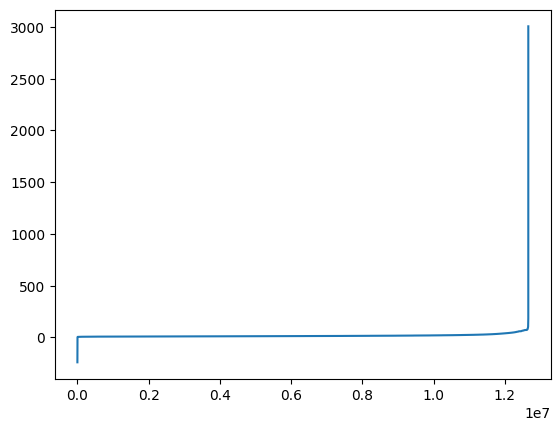

In [50]:
# Plotting fare values (sorted) to identify sharp increases and potential outliers
plt.plot(total_amount_sorted[:-2])
plt.show()

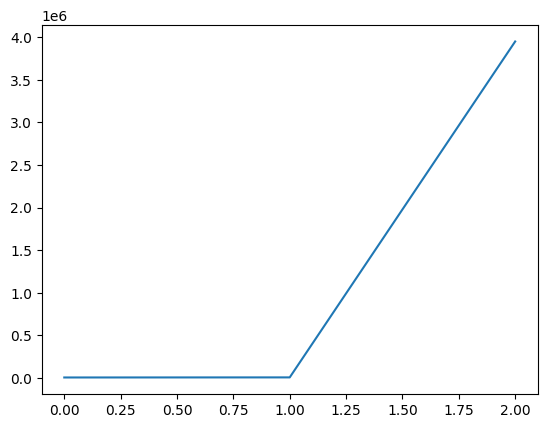

In [51]:
# A very sharp increase in fare values can be seen.
# Plotting last three total fare values to observe the sharp increase.
plt.plot(total_amount_sorted[-3:])
plt.show()

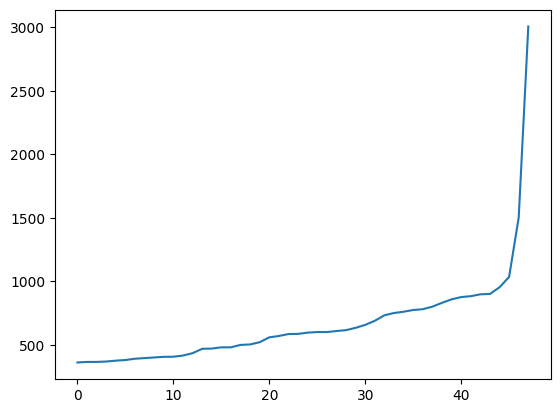

In [52]:
# Now, looking at values excluding the last two points, we again find a drastic increase at around 1000 fare value.
# Plotting last 50 values, excluding the last two values.
plt.plot(total_amount_sorted[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [61]:
#we are removing all outliers based on our univariate analysis above 

def print_outlier_analysis_details(initial_shape, final_shape, outlier_type):
    outliers_removed = initial_shape - final_shape
    print(f"Number of outliers from {outlier_type} analysis: {outliers_removed}")


def detach_outliers(frameNew):
    initial_shape = frameNew.shape[0]
    print("Number of pickup records =", initial_shape)
    
    # Removing outliers based on pickup and dropoff coordinates
    temp_frame = frameNew[
        ((frameNew.dropoff_longitude >= -74.15) & (frameNew.dropoff_longitude <= -73.7004) &
         (frameNew.dropoff_latitude >= 40.5774) & (frameNew.dropoff_latitude <= 40.9176)) &
        ((frameNew.pickup_longitude >= -74.15) & (frameNew.pickup_latitude >= 40.5774) &
         (frameNew.pickup_longitude <= -73.7004) & (frameNew.pickup_latitude <= 40.9176))
    ]
    print_outlier_analysis_details(initial_shape, temp_frame.shape[0], "NY boundaries")

    # Removing outliers based on trip times
    temp_frame = frameNew[(frameNew.trip_times > 0) & (frameNew.trip_times < 720)]
    print_outlier_analysis_details(initial_shape, temp_frame.shape[0], "trip times")

    # Removing outliers based on trip distances
    temp_frame = frameNew[(frameNew.trip_distance > 0) & (frameNew.trip_distance < 23)]
    print_outlier_analysis_details(initial_shape, temp_frame.shape[0], "trip distance")

    # Removing outliers based on cab speeds
    temp_frame = frameNew[(frameNew.Speed <= 65) & (frameNew.Speed >= 0)]
    print_outlier_analysis_details(initial_shape, temp_frame.shape[0], "speed")

    # Removing outliers based on fare amount
    temp_frame = frameNew[(frameNew.total_amount < 1000) & (frameNew.total_amount > 0)]
    print_outlier_analysis_details(initial_shape, temp_frame.shape[0], "fare")



    frameNew = frameNew[((frameNew.dropoff_longitude >= -74.15) & (frameNew.dropoff_longitude <= -73.7004) &\
                       (frameNew.dropoff_latitude >= 40.5774) & (frameNew.dropoff_latitude <= 40.9176)) & \
                       ((frameNew.pickup_longitude >= -74.15) & (frameNew.pickup_latitude >= 40.5774)& \
                       (frameNew.pickup_longitude <= -73.7004) & (frameNew.pickup_latitude <= 40.9176))]
    
    frameNew = frameNew[(frameNew.trip_times > 0) & (frameNew.trip_times < 720)]
    frameNew = frameNew[(frameNew.trip_distance > 0) & (frameNew.trip_distance < 23)]
    frameNew = frameNew[(frameNew.Speed < 45.31) & (frameNew.Speed > 0)]
    frameNew = frameNew[(frameNew.total_amount <1000) & (frameNew.total_amount >0)]

    print("Total outliers removed:", initial_shape - frameNew.shape[0])
    print("---")
    
    return frameNew

In [164]:
print ("Removing outliers in the month of Jan-2022")
print ("----")
frameWithDurations_outliers_removed = detach_outliers(frameWithDurations)
print("fraction of data points that remain after removing outliers", float(len(frameWithDurations_outliers_removed))/len(frameWithDurations))

Removing outliers in the month of Jan-2022
----
Number of pickup records = 12748986
Number of outliers from NY boundaries analysis: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed: 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation
## Clustering/Segmentation

In [66]:
# Evaluate optimal K for K-means clustering by analyzing inter-cluster distances

# Extract coordinate data
coordinates = frameWithDurations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
intercluster_statistics = []
#coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
#neighbours=[]



def calculate_cluster_distances(centers, num_centers):
    close_clusters = []
    distant_clusters = []
    smallest_distance = float('inf')
    for idx in range(num_centers):
        nearby_count = 0
        far_count = 0
        for other_idx in range(num_centers):
            if other_idx != idx:
                dist = gpxpy.geo.haversine_distance(centers[idx][0], centers[idx][1], centers[other_idx][0], centers[other_idx][1])
                normalized_dist = dist / 1609.34  # Convert meters to miles
                smallest_distance = min(smallest_distance, normalized_dist)
                if normalized_dist <= 2:
                    nearby_count += 1
                else:
                    far_count += 1
        close_clusters.append(nearby_count)
        distant_clusters.append(far_count)
    intercluster_statistics.append(close_clusters)
    print(f"Cluster size: {num_centers}")
    print(f"Average Nearby Clusters (distance < 2 miles): {np.ceil(np.mean(close_clusters))}")
    print(f"Average Distant Clusters (distance > 2 miles): {np.ceil(np.mean(distant_clusters))}")
    print(f"Minimum Inter-cluster Distance: {smallest_distance} miles\n---")

def assess_cluster_sizes(step):
    for k in range(10, 90, step):
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42).fit(coordinates)
        frameWithDurations_outliers_removed['pickup_cluster'] = kmeans.predict(frameWithDurations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
        cluster_centers = kmeans.cluster_centers_
        num_clusters = len(cluster_centers)
        calculate_cluster_distances(cluster_centers, num_clusters)


assess_cluster_sizes(10)


Cluster size: 10
Average Nearby Clusters (distance < 2 miles): 3.0
Average Distant Clusters (distance > 2 miles): 7.0
Minimum Inter-cluster Distance: 0.913203926561319 miles
---
Cluster size: 20
Average Nearby Clusters (distance < 2 miles): 5.0
Average Distant Clusters (distance > 2 miles): 14.0
Minimum Inter-cluster Distance: 0.6304295841719528 miles
---
Cluster size: 30
Average Nearby Clusters (distance < 2 miles): 8.0
Average Distant Clusters (distance > 2 miles): 22.0
Minimum Inter-cluster Distance: 0.4976644006283066 miles
---
Cluster size: 40
Average Nearby Clusters (distance < 2 miles): 11.0
Average Distant Clusters (distance > 2 miles): 29.0
Minimum Inter-cluster Distance: 0.3610260711922444 miles
---
Cluster size: 50
Average Nearby Clusters (distance < 2 miles): 13.0
Average Distant Clusters (distance > 2 miles): 37.0
Minimum Inter-cluster Distance: 0.3184877347528248 miles
---
Cluster size: 60
Average Nearby Clusters (distance < 2 miles): 16.0
Average Distant Clusters (distan

In [67]:
print(frameWithDurations_outliers_removed.shape)


(12371076, 11)


### Inference:
- The primary goal was to determine an optimal minimum distance between clusters, which approximates the radius of each cluster. The identified optimal minimum distance is approximately 40 units.

In [68]:
# Observation: Within the 50-cluster model, the minimum distance between any two clusters is only 0.3 miles.
# Decision: Opt for 40 clusters to better manage cluster proximity and address subsequent analytical tasks.

# Implementing K-means clustering to group data into 40 clusters

kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000, random_state=0).fit(coordinates)
frameWithDurations_outliers_removed['pickup_cluster'] = kmeans.predict(frameWithDurations_outliers_removed[['pickup_latitude', 'pickup_longitude']])


### Plotting the cluster centers:

In [69]:
# Retrieve cluster centers from the KMeans model
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

# Initialize a map centered around a specific geographical point (New York City coordinates)
nyc_coordinates = [40.734695, -73.990372]
nyc_map = folium.Map(location=nyc_coordinates, zoom_start=12)

# Create and add markers for each cluster center to the map
for latitude, longitude in cluster_centers:
    marker_location = [latitude, longitude]
    popup_label = f"Lat: {latitude:.5f}, Long: {longitude:.5f}"
    folium.Marker(marker_location, popup=popup_label).add_to(nyc_map)

# Display the map with all cluster markers
nyc_map


### Plotting the clusters:

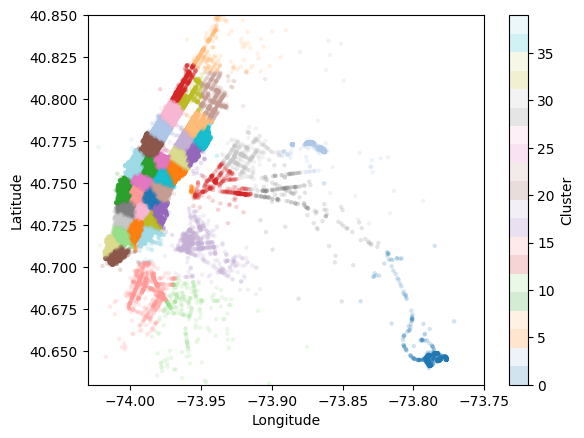

In [71]:
'''
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)
'''

def clusterPlot(dataframe):
    # Define the geographical boundaries for the city visualization
    longitude_bounds = (-74.03, -73.75)
    latitude_bounds = (40.63, 40.85)
    
    # Create a single plot
    fig, ax = plt.subplots()
    
    # Plot the first 100,000 points to avoid overplotting and increase clarity
    scatter = ax.scatter(
        dataframe['pickup_longitude'].head(100000),
        dataframe['pickup_latitude'].head(100000),
        s=10, lw=0, alpha=0.2,  # Size and transparency of points
        c=dataframe['pickup_cluster'].head(100000),  # Color by cluster
        cmap='tab20'  # Color map to differentiate clusters
    )
    
    # Set the x and y limits based on city borders
    ax.set_xlim(longitude_bounds)
    ax.set_ylim(latitude_bounds)
    
    # Labeling the axes
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Optional: add a colorbar to the plot to show cluster colors
    plt.colorbar(scatter, ax=ax, label='Cluster')

    # Display the plot
    plt.show()

# Call the function with the appropriate dataframe
clusterPlot(frameWithDurations_outliers_removed)

## TimeBinning

In [72]:

# Unix timestamps for the start of each month for consecutive 
def pickupBins_addition(df,year,month):
    pickupTimes=[idx for idx in df['pickup_times'].values]
    unixTimes = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    # Select the start Unix timestamp for the given month and year
    startPickup=unixTimes[year-2015][month-1]
    # Convert all pickup times from GMT to EST (Eastern Standard Time)
    # EST is 5 hours behind GMT, thus offset is 300 minutes (300 * 60 seconds)
    tenminuteBinnedTimes=[(int((idx-startPickup)/600)+33) for idx in pickupTimes]
    df['pickup_bins'] = np.array(tenminuteBinnedTimes)
    return df


In [73]:
# Perform the following data processing steps:
# 1. Apply clustering to categorize data based on spatial proximity.
# 2. Create temporal bins for pickup times to simplify time series analysis.
# 3. Group the data by the assigned pickup clusters and temporal bins for aggregated analysis.

frameWithDurations_outliers_removed['pickup_cluster'] = kmeans.predict(frameWithDurations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2022_frame = pickupBins_addition(frameWithDurations_outliers_removed,2015,1)
jan_2022_groupby = jan_2022_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [74]:

jan_2022_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421367e+09   5.285319              24         2193  
1  1.420940e+09   9.983193              31         1482  
2  1.420940e+09  10.746269              12         1482  
3  1.420940e+09  16.071429              34         1482  
4  1.420940e+09   9.318378               5         1482

In [75]:
jan_2022_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              63                      93
               64                     206
               65                     263
               66                     302
               67                     287

In [77]:
# Script for preparing and processing data for specific months and performing analysis

# Steps for Data Preparation:
# 1. Filter required columns from the data.
# 2. Calculate additional metrics such as trip times, speed, and Unix timestamps for pickup times.
# 3. Remove outliers based on criteria for trip times, speed, trip duration, and total amount.
# 4. Assign pickup clusters to each data point using the K-means clustering model.
# 5. Bin pickup times into 10-minute intervals and label these bins.
# 6. Aggregate data by pickup cluster and time bins for further analysis.


def prepare_data_for_analysis(month,kmeans,year,month_number):
    
    print ("Return with trip times..")

    frameWithDurations = calculate_tripTimes(month)
    
    #print values
    print("Removing outliers...")
    cleanedFrame = detach_outliers(frameWithDurations)
    
    print("Assigning pickup clusters...")
    cleanedFrame['pickup_cluster'] = kmeans.predict(cleanedFrame[['pickup_latitude', 'pickup_longitude']])
    
    print("Binning pickup times...")
    binned_frame = pickupBins_addition(cleanedFrame,year,month_number)
    print("Grouping data by cluster and time bins...")
    grouped_data = binned_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return binned_frame, grouped_data
    


jan_2023_frame,jan_2023_groupby = prepare_data_for_analysis(month_jan_2023,kmeans,2016,1)
feb_2023_frame,feb_2023_groupby = prepare_data_for_analysis(month_feb_2023,kmeans,2016,2)
mar_2023_frame,mar_2023_groupby = prepare_data_for_analysis(month_mar_2023,kmeans,2016,3)

Return with trip times..
Removing outliers...
Number of pickup records = 10906858
Number of outliers from NY boundaries analysis: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed: 297784
---
Assigning pickup clusters...
Binning pickup times...
Grouping data by cluster and time bins...
Return with trip times..
Removing outliers...
Number of pickup records = 11382049
Number of outliers from NY boundaries analysis: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed: 308177
---
Assigning pickup clusters...
Binning pickup times...
Grouping data by cluster and time bins...
Return with trip times..
Removing outliers...
Number of pickup records = 122

## Smoothing the data

In [108]:
# Function to retrieve unique, sorted lists of time bins with pickups for each cluster region.
# This helps identify which 10-minute intervals had pickups in each cluster.
'''def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values
'''

def get_unique_pickup_bins(frame):
    unique_bins_per_cluster = []
    for cluster_id in range(40):  # Considering there are 40 clusters indexed from 0 to 39
        # Filter frame for current cluster and get unique, sorted pickup_bins
        cluster_data = frame[frame['pickup_cluster'] == cluster_id]
        unique_bins = sorted(set(cluster_data['pickup_bins']))
        unique_bins_per_cluster.append(unique_bins)
    return unique_bins_per_cluster


In [109]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2022_unique = get_unique_pickup_bins(jan_2022_frame)
jan_2023_unique = get_unique_pickup_bins(jan_2023_frame)

#feb
feb_2023_unique = get_unique_pickup_bins(feb_2023_frame)

#march
mar_2023_unique = get_unique_pickup_bins(mar_2023_frame)

In [110]:
total_intervals = 4464  # Total number of 10-minute intervals in the analysis period
for cluster_id in range(40):  # Assuming 40 clusters indexed from 0 to 39
    unique_intervals = len(set(jan_2022_unique[cluster_id]))
    zero_pickup_intervals = total_intervals - unique_intervals
    print(f"Cluster {cluster_id}: Number of 10-minute intervals with zero pickups: {zero_pickup_intervals}")
    print('-' * 60)

Cluster 0: Number of 10-minute intervals with zero pickups: 35
------------------------------------------------------------
Cluster 1: Number of 10-minute intervals with zero pickups: 112
------------------------------------------------------------
Cluster 2: Number of 10-minute intervals with zero pickups: 40
------------------------------------------------------------
Cluster 3: Number of 10-minute intervals with zero pickups: 273
------------------------------------------------------------
Cluster 4: Number of 10-minute intervals with zero pickups: 35
------------------------------------------------------------
Cluster 5: Number of 10-minute intervals with zero pickups: 32
------------------------------------------------------------
Cluster 6: Number of 10-minute intervals with zero pickups: 30
------------------------------------------------------------
Cluster 7: Number of 10-minute intervals with zero pickups: 53
------------------------------------------------------------
Cluste

There are two primary methods to handle missing values:

1. **Fill the missing value with zeros.**
2. **Fill the missing values with the average values calculated from available data points.**

**Detailed Filling Strategies Based on Missing Value Positions:**

- **Case 1: Missing values at the start**
  - **Example 1**: `_ _ _ x` => Each `_` becomes `ceil(x/4)`
  - **Example 2**: `_ _ x` => Each `_` becomes `ceil(x/3)`

- **Case 2: Missing values in the middle**
  - **Example 1**: `x _ _ y` => Each `_` becomes `ceil((x+y)/4)`
  - **Example 2**: `x _ _ _ y` => Each `_` becomes `ceil((x+y)/5)`

- **Case 3: Missing values at the end**
  - **Example 1**: `x _ _ _` => Each `_` becomes `ceil(x/4)`
  - **Example 2**: `x _` => Each `_` becomes `ceil(x/2)`

Each strategy involves computing the average of the available values surrounding the missing entries (either to the left, right, or both), and then dividing this total appropriately among the missing values. The `ceil` function is used to ensure that the filled values are whole numbers and to prevent underestimation.


In [111]:
'''
def fill_zeros(pickup_counts, unique_bins):
    """
    Fills zero for each 10-minute interval bin that has no pickup data across each region.

    Parameters:
    - pickup_counts (list of lists): Number of pickups that occurred in each region for each 10-minute interval.
    - unique_bins (list of sets): Sets of indices corresponding to 10-minute intervals where pickups occurred for each region.

    Returns:
    - list of lists: Smoothed data for each region with zero-filled intervals where no pickups occurred.
    """
    smoothed_data = []
    for region_index in range(40):  # Assuming there are 40 regions
        region_data = []
        pickup_index = 0  # Index to track position in pickup_counts
        for bin_index in range(4464):  # Assuming 4464 bins per region
            if bin_index in unique_bins[region_index]:
                region_data.append(pickup_counts[region_index][pickup_index])
                pickup_index += 1
            else:
                region_data.append(0)
        smoothed_data.append(region_data)
    return smoothed_data

'''
def fill_zeros(count_values,values):
    """
    Fills zero for each 10-minute interval bin that has no pickup data across each region.

    Parameters:
    - pickup_counts (list of lists): Number of pickups that occurred in each region for each 10-minute interval.
    - unique_bins (list of sets): Sets of indices corresponding to 10-minute intervals where pickups occurred for each region.

    Returns:
    - list of lists: Smoothed data for each region with zero-filled intervals where no pickups occurred.
    """
    regionsWithSmoothing=[]
    idx=0 # Index to track position in pickup_counts
    for r in range(0,40): # Assuming there are 40 regions
        smoothed_bins=[]
        for i in range(4464):# Assuming 4464 bins per region
            if i in values[r]:
                smoothed_bins.append(count_values[idx])
                idx+=1
            else:
                smoothed_bins.append(0)
        regionsWithSmoothing.extend(smoothed_bins)
    return regionsWithSmoothing

In [112]:
def apply_smoothing(count_values,values):
    """
    Smooths missing pickup data across specified intervals for all regions.

    Parameters:
    - pickup_counts (list of lists): Counts of pickups for each valid interval in each region.
    - valid_bins (list of sets): Sets of indices representing valid pickup intervals for each region.

    Returns:
    - List of lists: Smoothed pickup data for all regions.
    """
    # Total number of 10-minute intervals =4464
    regionsWithSmoothing=[] # Final smoothed data for all regions
    idx=0
    repeat=0 
    smoothed_value=0
    for rg in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0:  #------------
                repeat-=1
                continue
            if i in values[rg]: 
                # Directly use the known pickup coun
                smoothed_bins.append(count_values[idx]) 
            else:
                # Need to calculate smoothed value
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[rg]: 
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    # No valid data yet; look forward to find the next known value(Case 1)
                        smoothed_value=count_values[idx-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        idx-=1
                    else:
                    ## No more pickups, extrapolate with zeros(Case 2)
                        smoothed_value=(count_values[idx-1]+count_values[idx])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    # Smooth between the last known value and the next known value (or extrapolate if at the end)(Case 3)
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[rg]:
                            continue
                        else:
                            # No more pickups, extrapolate using the last known value
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[idx]*1.0/((right_hand_limit-i)+1)*1.0
                    # Fill all intervals from current i to next known index (or end) with the smoothed value
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            # Adjust index to skip over filled values
            idx+=1
        regionsWithSmoothing.extend(smoothed_bins)
    return regionsWithSmoothing


In [113]:
# Filling missing pickup counts with zeros for January 2022
# jan_2022_groupby['trip_distance'] represents the number of pickups that occurred
jan_2022_fill = fill_zeros(jan_2022_groupby['trip_distance'].values,jan_2022_unique)

# Smoothing the filled pickup counts for January 2022
jan_2022_smooth = apply_smoothing(jan_2022_groupby['trip_distance'].values,jan_2022_unique)

In [114]:
print("number of 10min intravels among all the clusters ",len(jan_2022_fill))

number of 10min intravels among all the clusters  178560


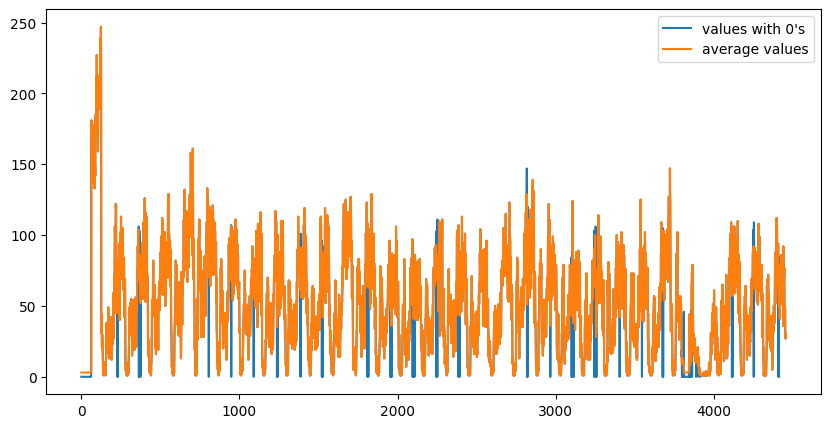

In [115]:
# Plotting to compare different methods of handling missing data
# We are using the data for the second cluster (index 1) from January 2022
# Assuming each cluster has 4464 data points

plt.figure(figsize=(10,5))
plt.plot(jan_2022_fill[4464:8920], label="values with 0's")
plt.plot(jan_2022_smooth[4464:8920], label="average values")
plt.legend()
plt.show()



In [116]:
# January-2022 data is smoothed, January,February & March 2023 data filled with 0 where there were values are missing
jan_2022_smooth = apply_smoothing(jan_2022_groupby['trip_distance'].values,jan_2022_unique)
jan_2023_smooth = fill_zeros(jan_2023_groupby['trip_distance'].values,jan_2023_unique)
feb_2023_smooth = fill_zeros(feb_2023_groupby['trip_distance'].values,feb_2023_unique)
mar_2023_smooth = fill_zeros(mar_2023_groupby['trip_distance'].values,mar_2023_unique)

# Creating the list of total values of pickup information for each bin for a span of 3 months and keepiong them region-wise 
cumRegion = []

for i in range(0,40):
    cumRegion.append(jan_2023_smooth[4464*i:4464*(i+1)]+feb_2023_smooth[4176*i:4176*(i+1)]+mar_2023_smooth[4464*i:4464*(i+1)])


## Time series and Fourier Transforms

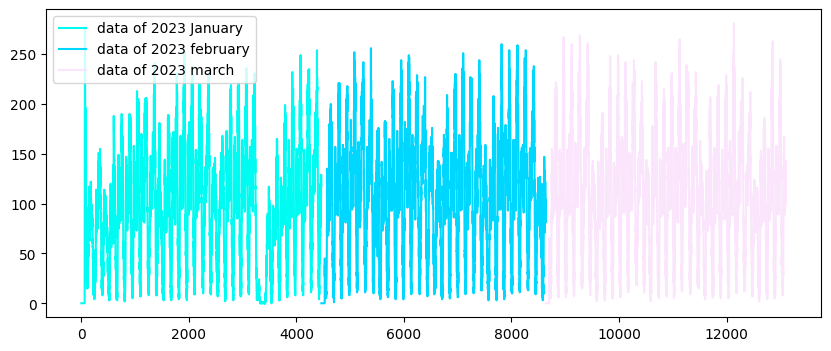

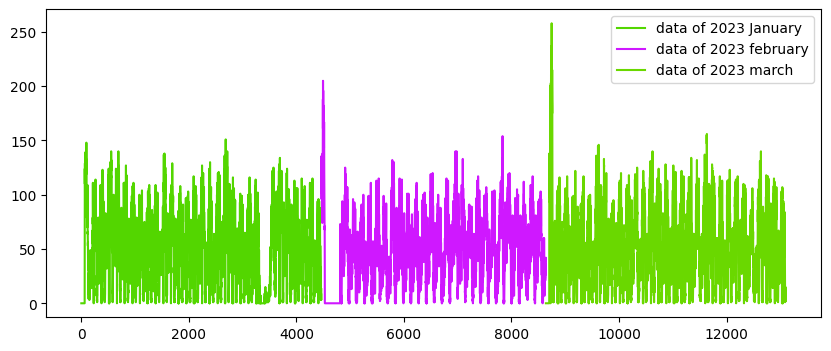

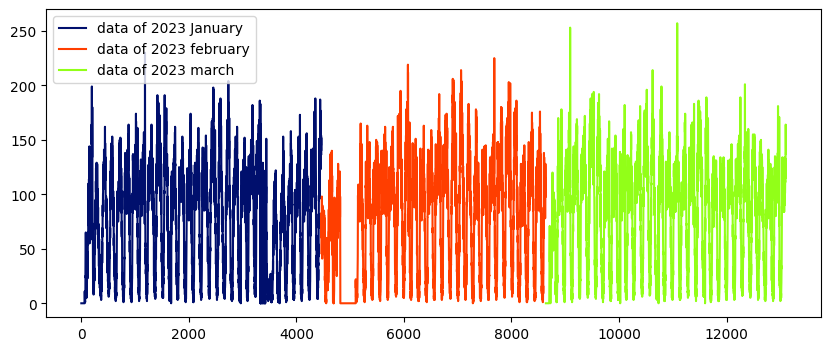

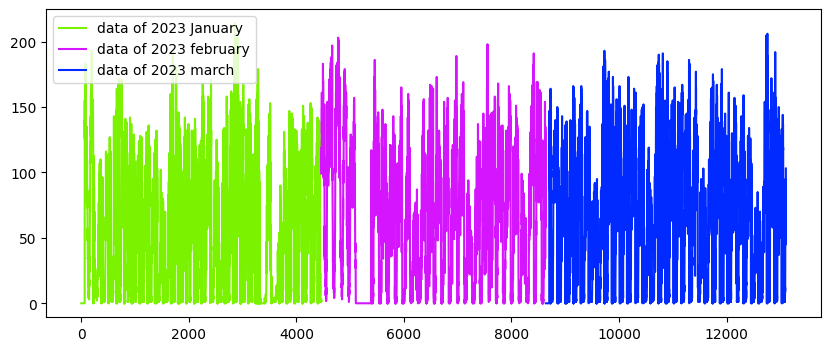

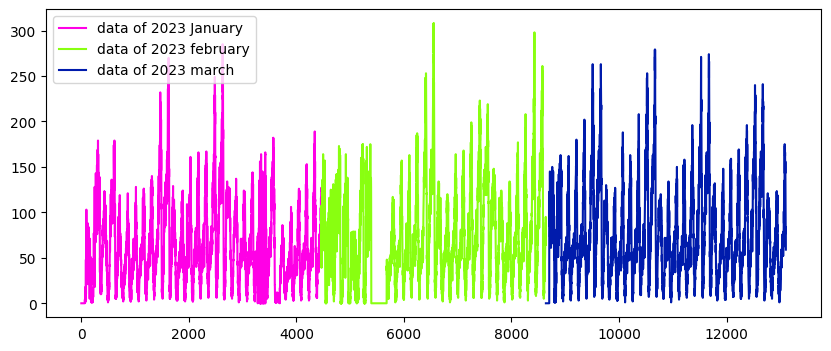

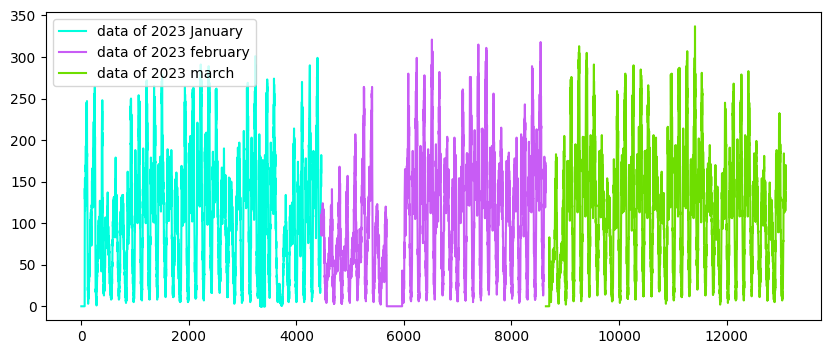

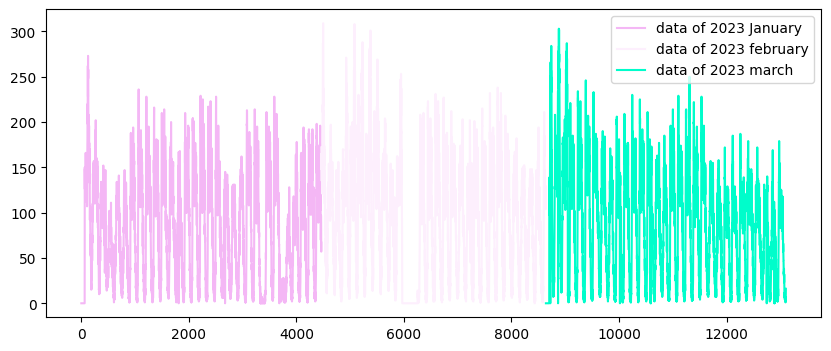

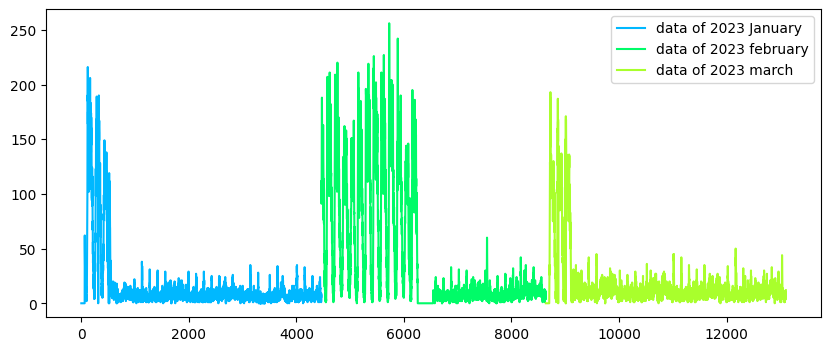

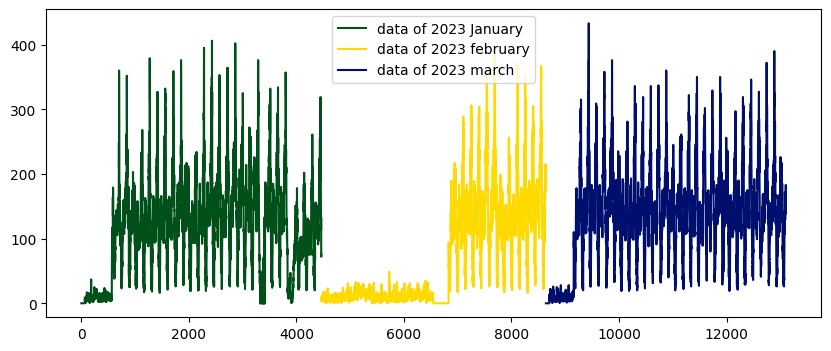

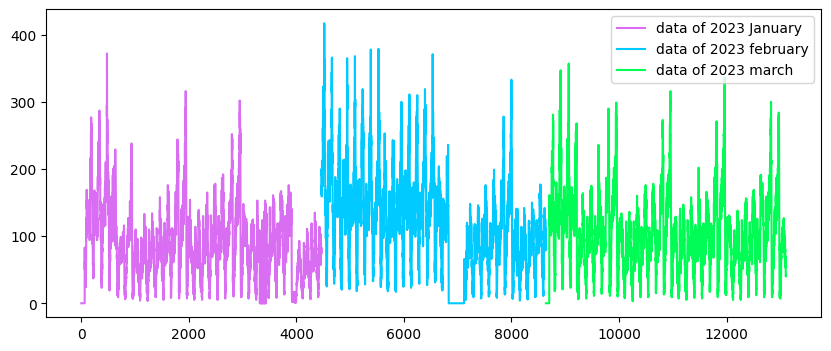

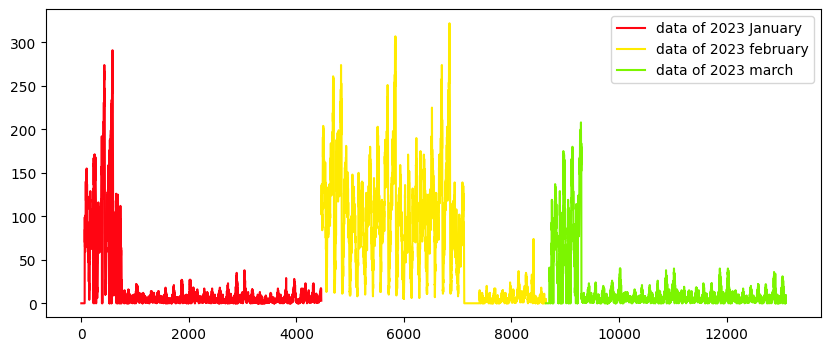

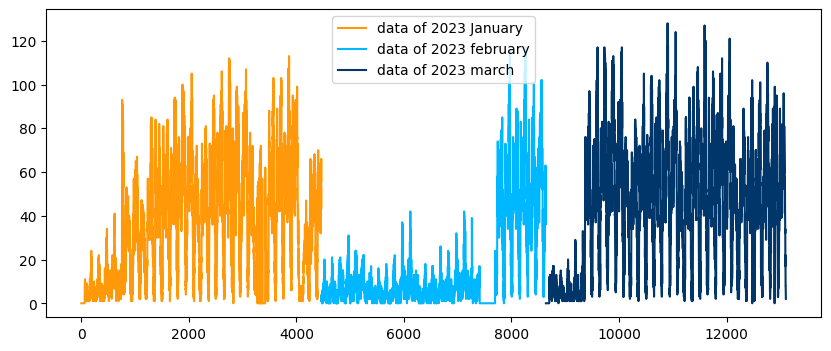

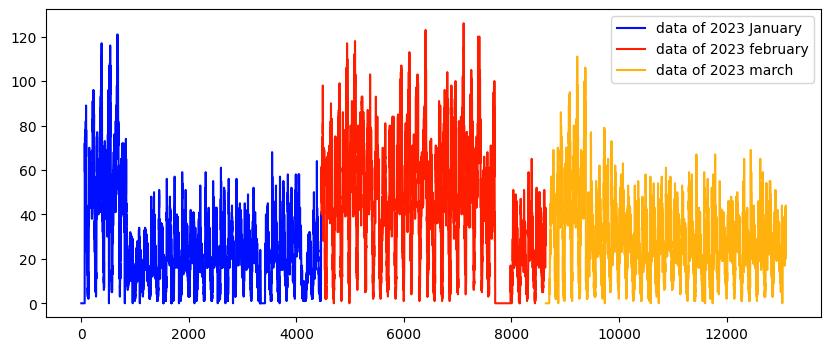

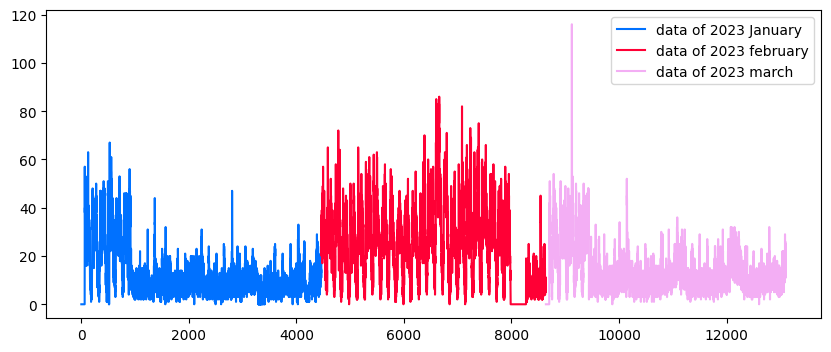

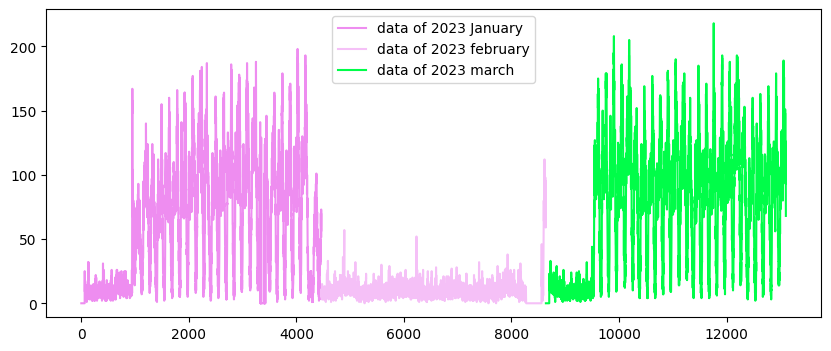

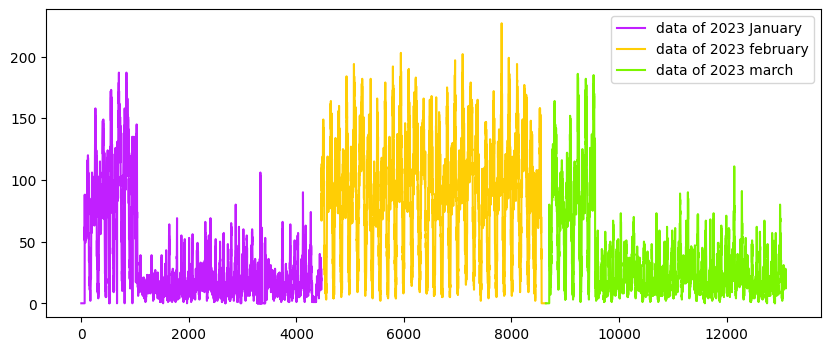

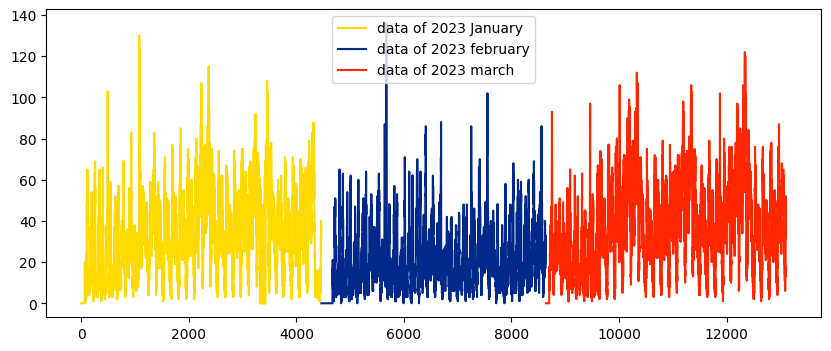

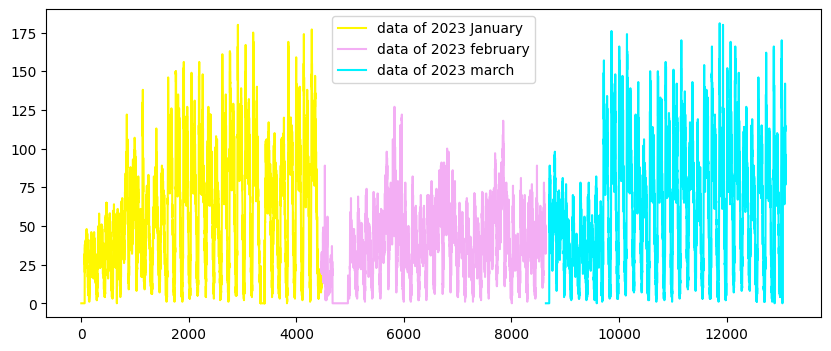

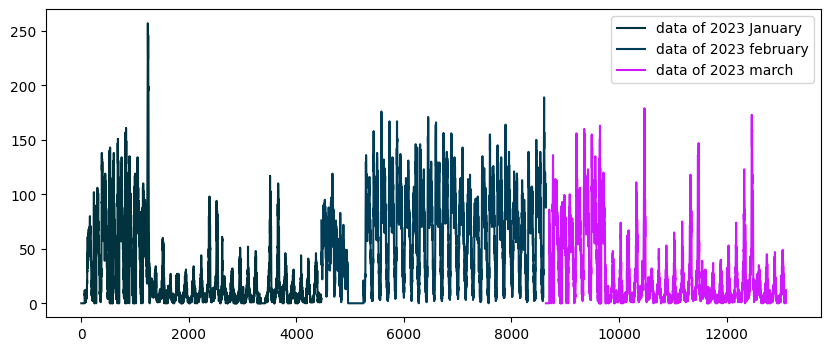

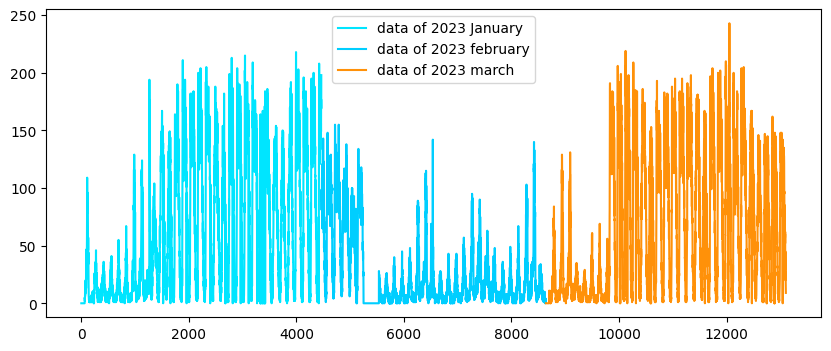

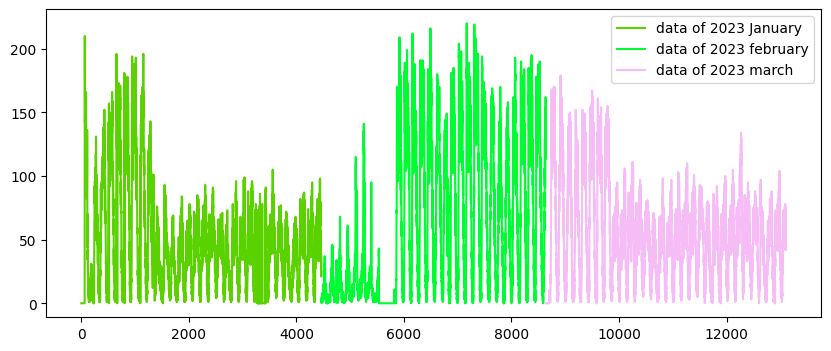

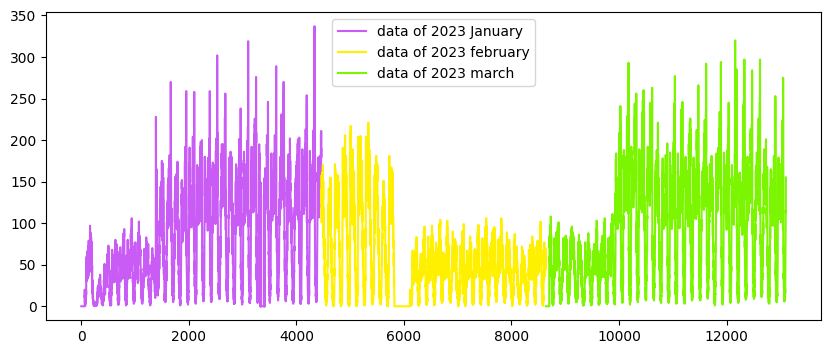

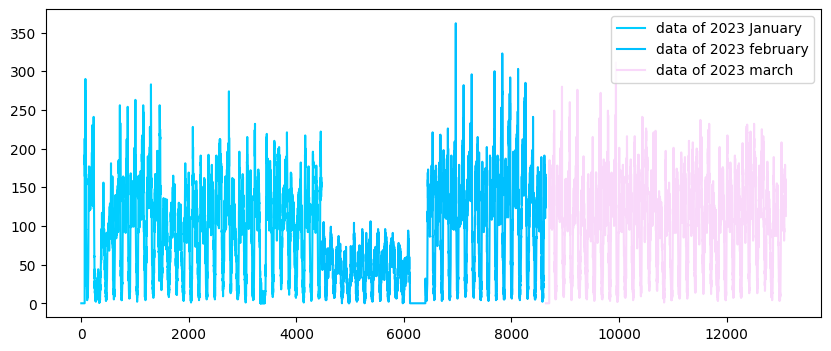

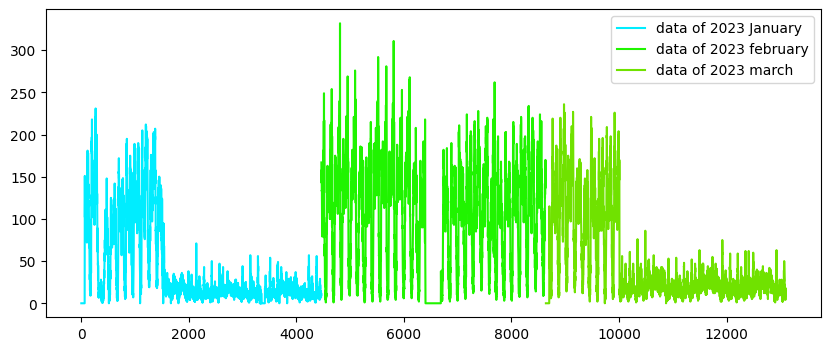

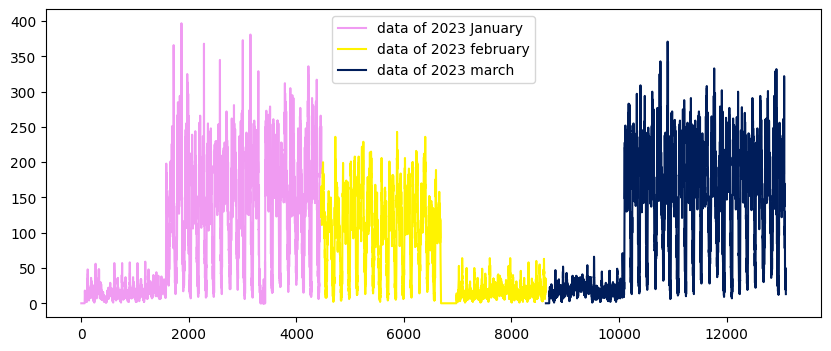

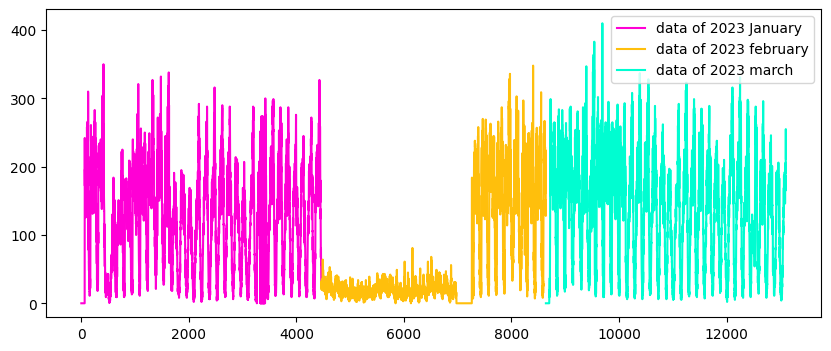

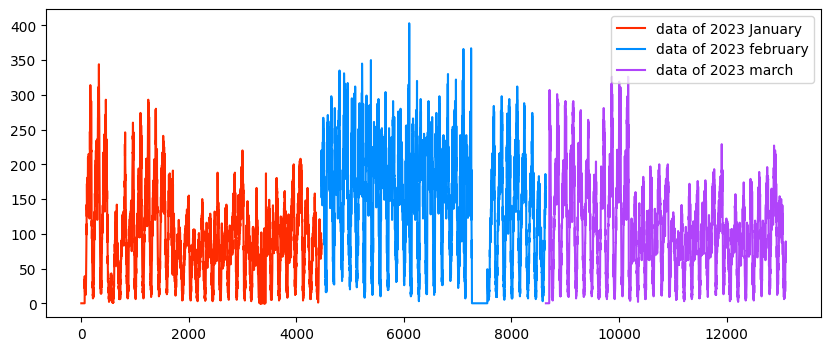

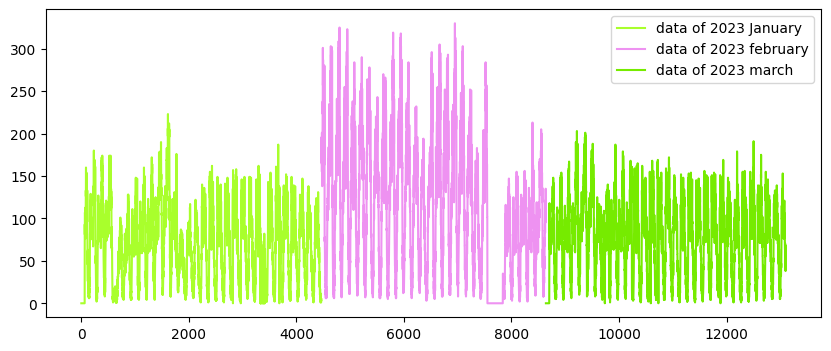

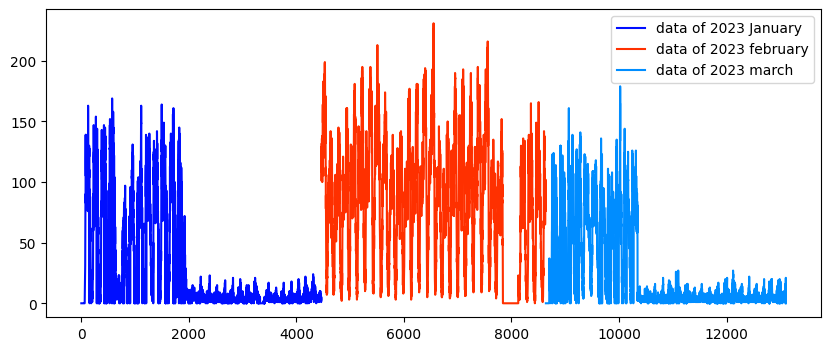

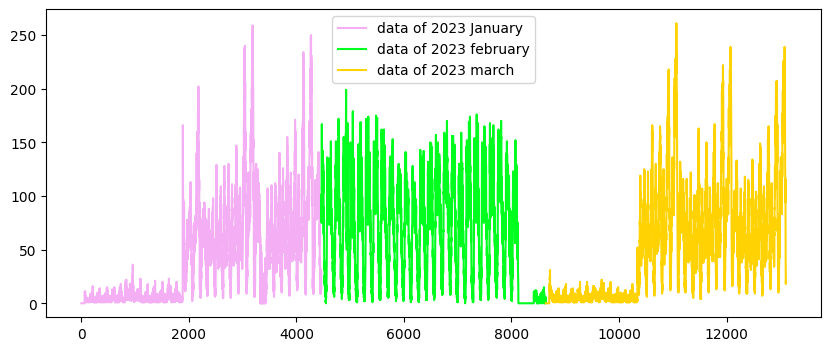

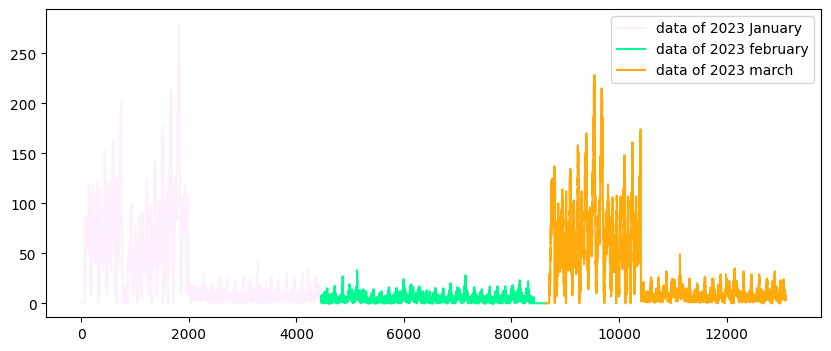

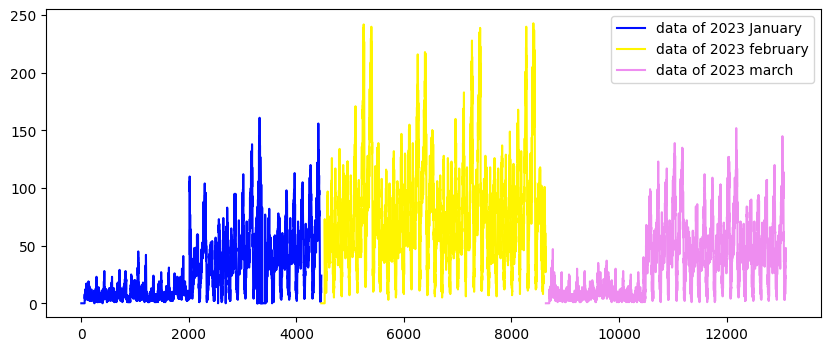

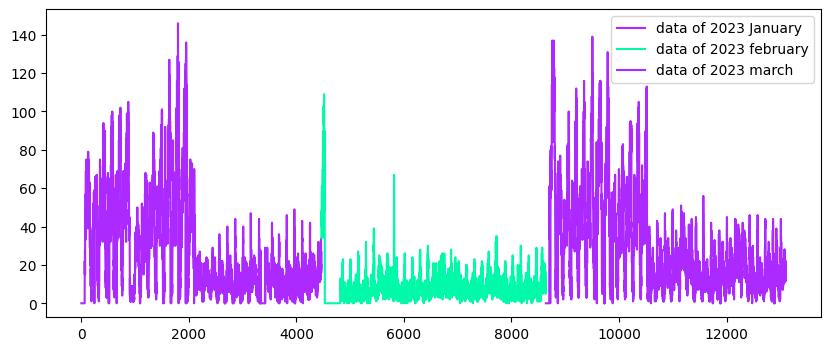

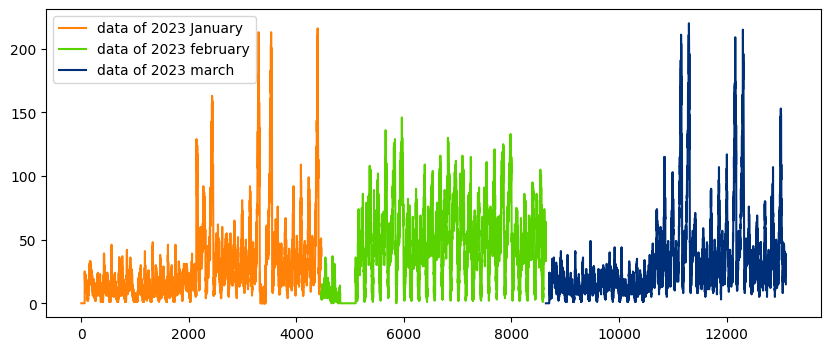

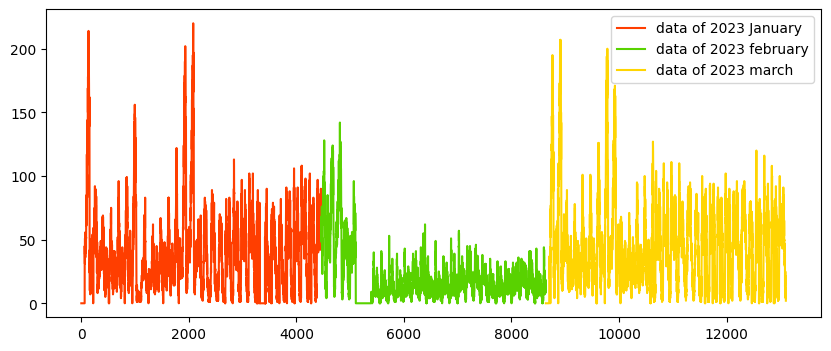

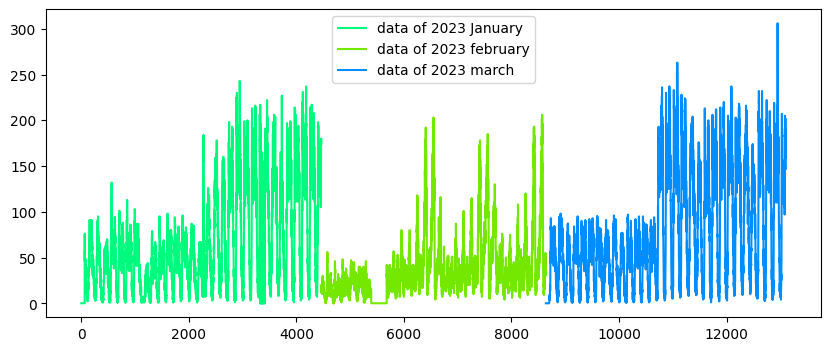

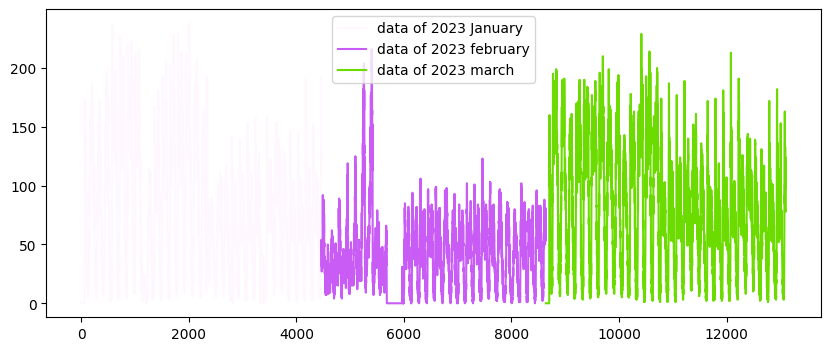

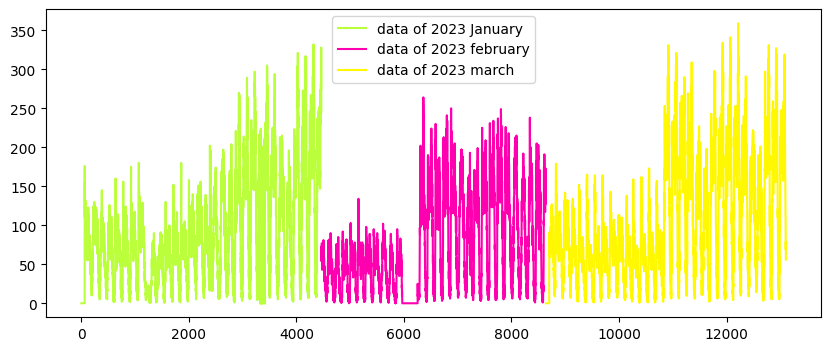

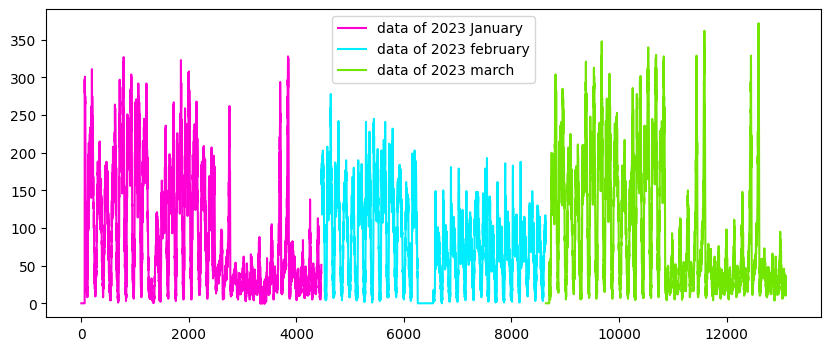

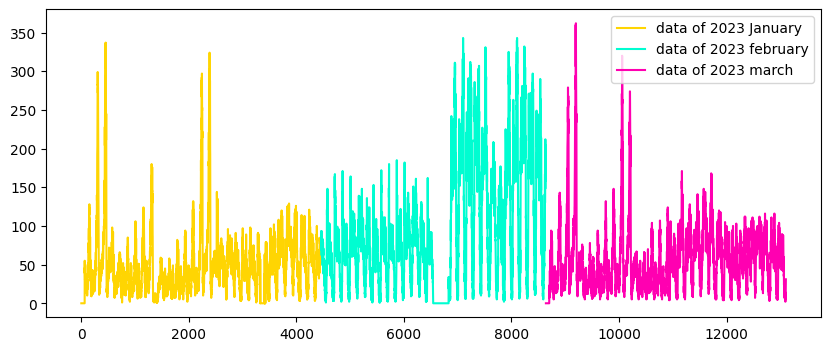

In [117]:
def special_color():
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for id in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,cumRegion[id][:4464], color=special_color(), label='data of 2023 January')
    plt.plot(second_x,cumRegion[id][4464:8640], color=special_color(), label='data of 2023 february')
    plt.plot(third_x,cumRegion[id][8640:], color=special_color(), label='data of 2023 march')
    plt.legend()
    plt.show()

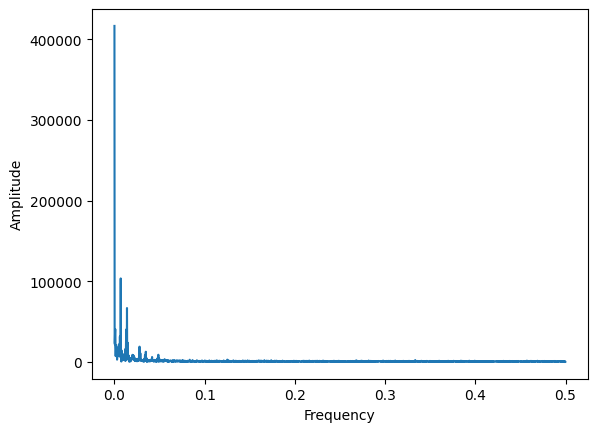

In [118]:
Z    = np.fft.fft(np.array(jan_2023_smooth)[0:4460])
frequen = np.fft.fftfreq(4460, 1)
n = len(frequen)
plt.figure()
plt.plot( frequen[:int(n/2)], np.abs(Z)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [127]:
#Preparing the Dataframe only with x(i) values as jan-2022 data and y(i) values as jan-2023
ratiosJanuary = pd.DataFrame()
ratiosJanuary['Given']=jan_2022_smooth
ratiosJanuary['Prediction']=jan_2023_smooth
ratiosJanuary['Ratios']=ratiosJanuary['Prediction']*1.0/ratiosJanuary['Given']*1.0

## Modeling: Baseline Approaches

We are now transitioning into the modeling phase aimed at forecasting pickup densities for the months of January, February, and March 2023. We will explore multiple modeling strategies, detailed as follows:

1. **Ratio-Based Forecasting**:
   - This method involves calculating the ratios of pickup densities between the corresponding months of 2023 and 2022. Specifically, the ratio \( Rt \) for a given time \( t \) is computed as follows:
     $\begin{align} R_{t} = P^{2023}_{t} / P^{2022}_{t} \end{align}$
   Where  $\begin{align} P^{2023}_{t} and P^{2022}_{t} \end{align}$ represent the pickup numbers in 2023 and 2022, respectively.

2. **Autoregressive Forecasting**:
   - This approach utilizes the previously known values from early 2023 to predict future values within the same year. The model assumes that future densities are primarily influenced by the immediate past densities, leveraging time series forecasting techniques.

Each method will be evaluated to determine its effectiveness in accurately forecasting monthly pickup densities.


### Simple Moving Averages Model

The first model we employ is the **Simple Moving Averages (SMA) Model**. This model forecasts the next value by calculating the average of the previous \( n \) values from the dataset. It operates under the assumption that the future value is likely to be around this average, making it a straightforward yet effective method for time series forecasting when data exhibits minimal fluctuation over time.


Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [128]:
def predictions_MA_R(ratios,month):
    ratioForecasted=(ratios['Ratios'].values)[0]
    error=[]
    valuesPredicted=[]
    sizeOfWindow=3
    ratiosValuesPredicted=[]
    for i in range(0,4464*40):
        if i%4464==0:
            ratiosValuesPredicted.append(0)
            valuesPredicted.append(0)
            error.append(0)
            continue
        ratiosValuesPredicted.append(ratioForecasted)
        valuesPredicted.append(int(((ratios['Given'].values)[i])*ratioForecasted))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*ratioForecasted)-(ratios['Prediction'].values)[i],1))))
        if i+1>=sizeOfWindow:
            ratioForecasted=sum((ratios['Ratios'].values)[(i+1)-sizeOfWindow:(i+1)])/sizeOfWindow
        else:
            ratioForecasted=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = valuesPredicted
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2023  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [129]:
def predictions_MA_P(ratios,month):
    valuesForecasted=(ratios['Prediction'].values)[0]
    error=[]
    valuesPredicted=[]
    sizeOfWindow=1
    ratiosValuesPredicted=[]
    for i in range(0,4464*40):
        valuesPredicted.append(valuesForecasted)
        error.append(abs((math.pow(valuesForecasted-(ratios['Prediction'].values)[i],1))))
        if i+1>=sizeOfWindow:
            valuesForecasted=int(sum((ratios['Prediction'].values)[(i+1)-sizeOfWindow:(i+1)])/sizeOfWindow)
        else:
            valuesForecasted=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = valuesPredicted
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2023 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages


Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [130]:
def predictions_WA_R(ratios,month):
    ratioForecasted=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    valuesPredicted=[]
    sizeOfWindow=5
    ratiosValuesPredicted=[]
    for i in range(0,4464*40):
        if i%4464==0:
            ratiosValuesPredicted.append(0)
            valuesPredicted.append(0)
            error.append(0)
            continue
        ratiosValuesPredicted.append(ratioForecasted)
        valuesPredicted.append(int(((ratios['Given'].values)[i])*ratioForecasted))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*ratioForecasted)-(ratios['Prediction'].values)[i],1))))
        if i+1>=sizeOfWindow:
            sum_values=0
            sum_of_coeff=0
            for j in range(sizeOfWindow,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-sizeOfWindow+j]
                sum_of_coeff+=j
            ratioForecasted=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            ratioForecasted=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = valuesPredicted
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2023 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [131]:
def predictions_WA_P(ratios,month):
    valuesForecasted=(ratios['Prediction'].values)[0]
    error=[]
    valuesPredicted=[]
    sizeOfWindow=2
    for i in range(0,4464*40):
        valuesPredicted.append(valuesForecasted)
        error.append(abs((math.pow(valuesForecasted-(ratios['Prediction'].values)[i],1))))
        if i+1>=sizeOfWindow:
            sum_values=0
            sum_of_coeff=0
            for j in range(sizeOfWindow,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-sizeOfWindow+j]
                sum_of_coeff+=j
            valuesForecasted=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            valuesForecasted=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = valuesPredicted
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2023 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [132]:
def predictions_EA_R1(ratios,month):
    ratioForecasted=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    valuesPredicted=[]
    ratiosValuesPredicted=[]
    for i in range(0,4464*40):
        if i%4464==0:
            ratiosValuesPredicted.append(0)
            valuesPredicted.append(0)
            error.append(0)
            continue
        ratiosValuesPredicted.append(ratioForecasted)
        valuesPredicted.append(int(((ratios['Given'].values)[i])*ratioForecasted))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*ratioForecasted)-(ratios['Prediction'].values)[i],1))))
        ratioForecasted = (alpha*ratioForecasted) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = valuesPredicted
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [133]:
def predictions_EA_P1(ratios,month):
    valuesForecasted= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    valuesPredicted=[]
    for i in range(0,4464*40):
        if i%4464==0:
            valuesPredicted.append(0)
            error.append(0)
            continue
        valuesPredicted.append(valuesForecasted)
        error.append(abs((math.pow(valuesForecasted-(ratios['Prediction'].values)[i],1))))
        valuesForecasted =int((alpha*valuesForecasted) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = valuesPredicted
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [134]:
errMean=[0]*10
errMedian=[0]*10
ratiosJanuary,errMean[0],errMedian[0]=predictions_MA_R(ratiosJanuary,'jan')
ratiosJanuary,errMean[1],errMedian[1]=predictions_MA_P(ratiosJanuary,'jan')
ratiosJanuary,errMean[2],errMedian[2]=predictions_WA_R(ratiosJanuary,'jan')
ratiosJanuary,errMean[3],errMedian[3]=predictions_WA_P(ratiosJanuary,'jan')
ratiosJanuary,errMean[4],errMedian[4]=predictions_EA_R1(ratiosJanuary,'jan')
ratiosJanuary,errMean[5],errMedian[5]=predictions_EA_P1(ratiosJanuary,'jan')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [136]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",errMean[0],"      MSE: ",errMedian[0])
print ("Moving Averages (2023 Values) -                        MAPE: ",errMean[1],"       MSE: ",errMedian[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",errMean[2],"      MSE: ",errMedian[2])
print ("Weighted Moving Averages (2023 Values) -               MAPE: ",errMean[3],"      MSE: ",errMedian[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",errMean[4],"      MSE: ",errMedian[4])
print ("Exponential Moving Averages (2023 Values) -         MAPE: ",errMean[5],"      MSE: ",errMedian[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.24831323742412317       MSE:  1870.9253472222222
Moving Averages (2023 Values) -                        MAPE:  0.1570793766914208        MSE:  252.14505488351256
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.2488305654278505       MSE:  1548.9681227598567
Weighted Moving Averages (2023 Values) -               MAPE:  0.14863634287513972       MSE:  221.93309811827956
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.25094488325911674       MSE:  1564.4670082885305
Exponential Moving Averages (2023 Values) -         MAPE:  0.14834194

<b>Plese Note:-</b> The above comparisons are made using Jan 2022 and Jan 2023 only

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2023 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [137]:
# Define the number of timestamps to consider
no_of_timeStamps = 5

# Output variable
output = []


# Latitude of cluster centers
latitudeTsne = []


# Longitude of cluster centers
longitudeTsne = []

# Weekday of each timestamp
weekdayTsne = []

# Features for each timestamp
featureTsne = []


featureTsne = [0]*no_of_timeStamps

# Populate lists for each cluster
for idx in range(0,40):
    latitudeTsne.append([kmeans.cluster_centers_[idx][0]]*13099)
    longitudeTsne.append([kmeans.cluster_centers_[idx][1]]*13099)

    # Calculate weekday for each timestamp
    weekdayTsne.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # Extract features for each timestamp
    featureTsne = np.vstack((featureTsne, [cumRegion[idx][r:r+no_of_timeStamps] for r in range(0,len(cumRegion[idx])-no_of_timeStamps)]))
    # Populate output with region data
    output.append(cumRegion[idx][5:])
featureTsne = featureTsne[1:]

In [138]:
len(latitudeTsne[0])*len(latitudeTsne) == featureTsne.shape[0] == len(weekdayTsne)*len(weekdayTsne[0]) == 40*13099 == len(output)*len(output[0])

True

In [139]:
# Define alpha for exponential weighted moving average
alpha=0.3

# Temporary array to store predicted values
valuesPredicted=[]

# Initialize lists to store predicted values and features

# List of predicted values
predict_list = []

# Exponential moving average feature
tsne_flat_exp_avg = []

for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            valuesForecasted= cumRegion[r][0]
            valuesPredicted.append(0)
            continue
        valuesPredicted.append(valuesForecasted)
        valuesForecasted =int((alpha*valuesForecasted) + (1-alpha)*(cumRegion[r][i]))
    predict_list.append(valuesPredicted[5:])
    valuesPredicted=[]

In [140]:
# Splitting the data into train and test sets with a 70% - 30% ratio.
# Before proceeding with tree-based regression model predictions, 
# we segment the pickup data from the first three months of 2023. 
# The split ensures that for each region, 70% of the data is allocated for training 
# while the remaining 30% is reserved for testing. 
# The data is organized chronologically for each region.
print("Train data size:", int(13099*0.7))
print("Test data size:", int(13099*0.3))

Train data size: 9169
Test data size: 3929


In [141]:
# Getting the first 9169 timestamps like 70% of 13099 (total no.of timestamps) for the sake of Training Data
featuresTrain =  [featureTsne[idx*13099:(13099*idx+9169)] for idx in range(0,40)]
# temp = [0]*(12955 - 9068)
featuresTest = [featureTsne[(13099*(idx))+9169:13099*(idx+1)] for idx in range(0,40)]

In [142]:
print("No. of data clusters",len(featuresTrain), "No. of rows in train data", len(featuresTrain[0]), "Each data point contains", len(featuresTrain[0][0]),"features")
print("No. of data clusters",len(featuresTrain), "No. of rows in test data", len(featuresTest[0]), "Each data point contains", len(featuresTest[0][0]),"features")

No. of data clusters 40 No. of rows in train data 9169 Each data point contains 5 features
No. of data clusters 40 No. of rows in test data 3930 Each data point contains 5 features


In [146]:
# getting top 9169 timestamps like 70.00 percentage of 13099 (total timestamps) for the sake of the training data
trainLatitudeTsneFlat = [i[:9169] for i in latitudeTsne]
trainLongitudeTsneFlat = [i[:9169] for i in longitudeTsne]
weekdayTrainTsneFlat = [i[:9169] for i in weekdayTsne]
outputTrainTsneFlat = [i[:9169] for i in output]
expAvgTrainTsneFlat = [i[:9169] for i in predict_list]

In [147]:
# Getting the remaining of the timestamps like 30.00 percasntage of 12956 (total timestamps) for the sake of the test data
testLatitudeTsneFlat = [i[9169:] for i in latitudeTsne]
testLongitudeTsneFlat = [i[9169:] for i in longitudeTsne]
weekdayTestTsneFlat = [i[9169:] for i in weekdayTsne]
outputTestTsneFlat = [i[9169:] for i in output]
expAvgTestTsneFlat = [i[9169:] for i in predict_list]

In [148]:
# The preceding data structure consists of nested lists, representing values for each region separately. 
# This step consolidates all values into a single list.
newFeatureTrain = []
for idx in range(0,40):
    newFeatureTrain.extend(featuresTrain[idx])
newFeatureTest = []
for idx in range(0,40):
    newFeatureTest.extend(featuresTest[idx])

In [149]:
# The conversion process entails flattening lists of lists into a single list.
# Example:
# a = [[1, 2, 3, 4], [4, 6, 7, 8]]
# print(sum(a, [])) 
# Output: [1, 2, 3, 4, 4, 6, 7, 8]

trainLatitudeTsne = sum(trainLatitudeTsneFlat, [])
trainLongitudeTsne = sum(trainLongitudeTsneFlat, [])
trainWeekdayTsne = sum(weekdayTrainTsneFlat, [])
trainOutputTsne = sum(outputTrainTsneFlat, [])
trainExpAvgTsne = sum(expAvgTrainTsneFlat,[])

In [150]:
# The conversion process entails flattening lists of lists into a single list.
# Example:
# a = [[1, 2, 3, 4], [4, 6, 7, 8]]
# print(sum(a, [])) 
# Output: [1, 2, 3, 4, 4, 6, 7, 8]

testLatitudeTsne = sum(testLatitudeTsneFlat, [])
testLongitudeTsne = sum(testLongitudeTsneFlat, [])
testWeekdayTsne = sum(weekdayTestTsneFlat, [])
testOutputTsne = sum(outputTestTsneFlat, [])
testExpAvgTsne = sum(expAvgTestTsneFlat,[])

In [151]:
# building the df for the training data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
trainDf = pd.DataFrame(data=newFeatureTrain, columns=columns) 
trainDf['lat'] = trainLatitudeTsne
trainDf['lon'] = trainLongitudeTsne
trainDf['weekday'] = trainWeekdayTsne
trainDf['exp_avg'] = trainExpAvgTsne

print(trainDf.shape)

(366760, 9)


In [152]:
# building the df for the testiung data
testDf = pd.DataFrame(data=newFeatureTest, columns=columns) 
testDf['lat'] = testLatitudeTsne
testDf['lon'] = testLongitudeTsne
testDf['weekday'] = testWeekdayTsne
testDf['exp_avg'] = testExpAvgTsne
print(testDf.shape)

(157200, 9)


In [153]:
testDf.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0    27    32    25    44    44  40.740669 -73.985884        4       42
1    32    25    44    44    54  40.740669 -73.985884        4       50
2    25    44    44    54    72  40.740669 -73.985884        4       65
3    44    44    54    72    84  40.740669 -73.985884        4       78
4    44    54    72    84    87  40.740669 -73.985884        4       84

### Using Linear Regression

In [154]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
linear_regg=LinearRegression().fit(trainDf, trainOutputTsne)

y_pred = linear_regg.predict(testDf)
linear_testPredictions = [round(value) for value in y_pred]
y_pred = linear_regg.predict(trainDf)
linear_trainPredictions = [round(value) for value in y_pred]

### Using Random Forest Regressor

In [155]:
# Default parameters for RandomForestRegressor:
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# Some essential methods of RandomForestRegressor:
# - apply(X): Apply trees in the forest to X and return leaf indices.
# - decision_path(X): Return the decision path in the forest.
# - fit(X, y[, sample_weight]): Build a forest of trees from the training set (X, y).
# - get_params([deep]): Get parameters for this estimator.
# - predict(X): Predict regression target for X.
# - score(X, y[, sample_weight]): Returns the coefficient of determination R^2 of the prediction.

rfreg1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
rfreg1.fit(trainDf, trainOutputTsne)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [156]:
# Making predictions on the test data using our trained Random Forest model.

# The model rfreg1 has already been hyperparameter-tuned.
# The parameters obtained above were determined using grid search.

y_pred = rfreg1.predict(testDf)
rfTestPredictions = [round(value) for value in y_pred]
y_pred = rfreg1.predict(trainDf)
rfTrainPredictions = [round(value) for value in y_pred]

In [157]:
#logging gthe feature importances with randomForestmodel
print (trainDf.columns)
print (rfreg1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.02429989 0.05119709 0.15191057 0.11468267 0.27349249 0.00270237
 0.00394356 0.00201716 0.3757542 ]


### Using XgBoost Regressor

In [158]:
# We're training a hyper-parameter tuned XGBoost regressor on our training data.

# For more details about the XGBRegressor function, visit the documentation: 
# http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# Default parameters for XGBRegressor:
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# Some essential methods of XGBRegressor:
# - fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None): 
#   Trains the model.
# - get_params([deep]): Retrieves parameters for this estimator.
# - predict(data, output_margin=False, ntree_limit=0): Predicts with the given data.
# - get_score(importance_type='weight') -> get the feature importance.

xgBostModel = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
xgBostModel.fit(trainDf, trainOutputTsne)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...)

In [159]:
# Making predictions on the test data utilising the trained XGBoost Regressor model.
# the models xgBostModel is already hyper parameter tuned
# The parameters obtained above were determined using grid search.

y_pred = xgBostModel.predict(testDf)
xgBostTestPredictions = [round(value) for value in y_pred]
y_pred = xgBostModel.predict(trainDf)
xgBostTrainPredictions = [round(value) for value in y_pred]

### Calculating the error metric values for various models

In [161]:
trainMAPE=[]
testMAPE=[]

trainMAPE.append((mean_absolute_error(trainOutputTsne,trainDf['ft_1'].values))/(sum(trainOutputTsne)/len(trainOutputTsne)))
trainMAPE.append((mean_absolute_error(trainOutputTsne,trainDf['exp_avg'].values))/(sum(trainOutputTsne)/len(trainOutputTsne)))
trainMAPE.append((mean_absolute_error(trainOutputTsne,rfTrainPredictions))/(sum(trainOutputTsne)/len(trainOutputTsne)))
trainMAPE.append((mean_absolute_error(trainOutputTsne, xgBostTrainPredictions))/(sum(trainOutputTsne)/len(trainOutputTsne)))
trainMAPE.append((mean_absolute_error(trainOutputTsne, linear_trainPredictions))/(sum(trainOutputTsne)/len(trainOutputTsne)))

testMAPE.append((mean_absolute_error(testOutputTsne, testDf['ft_1'].values))/(sum(testOutputTsne)/len(testOutputTsne)))
testMAPE.append((mean_absolute_error(testOutputTsne, testDf['exp_avg'].values))/(sum(testOutputTsne)/len(testOutputTsne)))
testMAPE.append((mean_absolute_error(testOutputTsne, rfTestPredictions))/(sum(testOutputTsne)/len(testOutputTsne)))
testMAPE.append((mean_absolute_error(testOutputTsne, xgBostTestPredictions))/(sum(testOutputTsne)/len(testOutputTsne)))
testMAPE.append((mean_absolute_error(testOutputTsne, linear_testPredictions))/(sum(testOutputTsne)/len(testOutputTsne)))

In [162]:
print ("Error Metric Matrix (Based on all models we applied) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",trainMAPE[0],"      Test: ",testMAPE[0])
print ("Exponential Averages Forecasting -           Train: ",trainMAPE[1],"      Test: ",testMAPE[1])
print ("XgBoost            -                         Train: ",trainMAPE[3],"      Test: ",testMAPE[3])
print ("Random Forest Regression -                   Train: ",trainMAPE[2],"     Test: ",testMAPE[2])
print ("Linear Regression -                          Train: ",trainMAPE[4],"     Test: ",testMAPE[4])


Error Metric Matrix (Based on all models we applied) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.149816683069746       Test:  0.14343514190172715
Exponential Averages Forecasting -           Train:  0.1417795535388316       Test:  0.13538262235221102
XgBoost            -                         Train:  0.1389008813961767       Test:  0.1324826007261561
Random Forest Regression -                   Train:  0.09913298876244912      Test:  0.13315163896775434
Linear Regression -                          Train:  0.1422646810594963      Test:  0.13493536053981064
